# Assignment 2
The objective of this assignment is to introduce you to function specific neural networks. In otherwords, we will try and design neural networks based on insights from existing optimization algorithms. In the process, you will realize that while deep neural networks can, in theory, be generalized to learn arbitrary functions, design choices determine how easily and quickly they are able to learn those functions.

Additionally, when the training process starts, the model has to learn a particular mapping with no prior hint about the kind of function it is looking for. By introducing a structure which correlates to optimization objectives, neural networks can effectively be helped in narrowing done the choice of functions and parameters to be learnt.

### Imports

In [1]:
import torch
import pickle
import shutil
import numpy as np
import scipy.linalg
import torch.nn as nn
from torch.linalg import svd
from torch.optim import Adam
from google.colab import drive
import torch.nn.functional as F
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from mpl_toolkits.mplot3d import Axes3D
from torch.utils.data import Dataset, DataLoader, random_split

np.random.seed(0)
gen = torch.Generator().manual_seed(0)

In [2]:
drive.mount('/content/drive')

# Step 1: Define the paths for the files in Google Drive and the destination path
drive_path_sparse = '/content/drive/MyDrive/sparse_signals.pkl'  # Update with correct path in Google Drive
drive_path_mnist = '/content/drive/MyDrive/moving_mnist.pkl'    # Update with correct path in Google Drive
destination_dir = '/content/'

# Step 2: Copy the files from Google Drive to Colab's /content directory
shutil.copy(drive_path_sparse, destination_dir)
shutil.copy(drive_path_mnist, destination_dir)

print('copied both files successfully')

Mounted at /content/drive
copied both files successfully


# Task 1: Sparsity and Robustness

Please add your solution to this task from the manual in the cells below.

In [ ]:
#check other notebook and report

# Task 2: Sparsity in Contrastive Models

Please add your solution to this task from the manual in the cells below.

In [ ]:
#check other notebook and report

# Task 3: ISTA for Sparse Vector Recovery

## Section 1: Optimization

We first start by considering a well formulated problem:

Consider some noisy observations $\mathbf{x} \in \mathbb{R}^{m}$ generated from the following process:

$$
\begin{align}
\mathbf{x} = \mathbf{Az} + \mathbf{n}
\end{align}
$$

where $\mathbf{z} \in \mathbb{R}^{m}$ is our target signal, $\mathbf{A} \in \mathbb{R}^{m \times n}$ is a linear operator representing the process by which the signal has been measured, and $\mathbf{n} \in \mathbb{R}^{n}$ represents additive noise. Our objective is to recover $\mathbf{x}$.


This can be formulated as an optimization problem as follows:
$$
\begin{align}
\min_{\mathbf{z}} ||\mathbf{x} - \mathbf{Az}||_{2}^{2}
\end{align}
$$

This is the well known, least squares regression problem and there are various methods to solve it. We make our problem more interesting by adding the constraint that $\mathbf{x}$ is **sparse**. Noting that the $l_{0}$ norm measures sparsity, our new optimization problem is:

$$
\begin{align}
\min_{\mathbf{z}} ||\mathbf{x} - \mathbf{Az}||_{2}^{2} + \lambda||\mathbf{z}||_{0}
\end{align}
$$

This problem is **not** convex and hence cannot be solved using conventional gradient based methods.

We relax the $l_{0}$ norm to the $l_{1}$ norm in order to bring our problem in the domain of convex problems:

$$
\begin{align}
\min_{\mathbf{z}} ||\mathbf{x} - \mathbf{Az}||_{2}^{2} + \lambda||\mathbf{z}||_{1}
\end{align}
$$

You may know this as lasso regression. Note that this problem is not solvable via gradient descent since the $l_{1}$ norm is not differentiable. Many solvers exist for this problem, but we shall take a different approach known as the **Iterative Soft Thresholding Algorithm (ISTA)**.

We can write our optimization objective as a sum of two functions:

$$
\begin{align}
\min_{\mathbf{z}}{h(\mathbf{z}) = f(\mathbf{z}) + g(\mathbf{z})}
\end{align}
$$

where $f$ is convex and differentiable while $g$ is convex but not necessarily differentiable.

Note that if $g$ was differentiable, we could use a gradient based approach (e.g. gradient descent) to minimize it. Our approach is to design an iterative algorithm such that at iteration $k$ where the algorithm is at point $\mathbf{z}_k$, we minimize another convex function $m_{k}$ fulfilling the following conditions:

$$
\begin{align}
m_{k}(\mathbf{z}) &\geq h(\mathbf{z}) \; \; ∀ \mathbf{z} \\
m_{k}(\mathbf{z}_{k}) &= h(\mathbf{z}_{k})
\end{align}
$$

Our update equation then becomes:
$$
\begin{align}
\mathbf{z}_{k+1} = \min_{\mathbf{z}}{m_{k}({\mathbf{z}})}
\end{align}
$$

Coming back to our problem, we define the following function:
$$
\begin{align}
m_{k}(\mathbf{z}) = ||\mathbf{x} - \mathbf{Az}||_{2}^{2} + λ||\mathbf{z}||_{1} + (\mathbf{z} - \mathbf{z}_{k})^{T}(α\mathbf{I} - \mathbf{A}^{T}\mathbf{A})(\mathbf{x} - \mathbf{z}_{k})
\end{align}
$$

Note that at $\mathbf{z} = \mathbf{z}_{k}$, the additional quadratic term becomes 0 while for all other $\mathbf{z}$, the additional term is positive as long as $α > \max(\text{eig}(\mathbf{A}^{T}\mathbf{A}))$ thereby satisfying the two conditions defined above. Each iterative step that minimizes this function, also minimizes the original objective function.
The expression for $\min_{\mathbf{z}}m_{k}(\mathbf{z}_{k})$ can be written as follows:

$$
\begin{align}
\min_{\mathbf{z}}{||\mathbf{z}_{k} + \frac{1}{\alpha}\mathbf{A}^{T}(\mathbf{x} - \mathbf{A}\mathbf{z}_{k}) - \mathbf{z}||_{2}^{2} + \frac{λ}{\alpha}||\mathbf{z}||_{1}}
\end{align}
$$
While an exact solution for the miniimzation problem does not exist, by finding a minimizer at each $k$, we can approach the global minimizer of the original problem.

Each update iteration looks as follows:
$$
\begin{align}
\mathbf{z}_{k+1} = \text{soft}(\mathbf{z}_{k} + \frac{1}{\alpha}\mathbf{A}(\mathbf{x} - \mathbf{A}^{T}\mathbf{z}_{k}), \frac{\lambda}{2\alpha})
\end{align}
$$

Where:
$$
\begin{align}
\text{soft}(\mathbf{x}, \tau) := \text{sign}(\mathbf{x})\max(0, |\mathbf{x}| - \tau)
\end{align}
$$

The soft thresholding operator is also known as the proximal gradient operator for the $l_{1}$ norm.

Consider the following example where $\mathbf{z} \in \mathbb{R}^{100}$,  $\mathbf{A} \in \mathbb{R}^{100 \times 100}$ and $\mathbf{n} \sim \mathcal{N}(0, 0.05^{2}\mathbf{I}) \in \mathbb{R}^{100}$:

Sparsity in z: 0.79


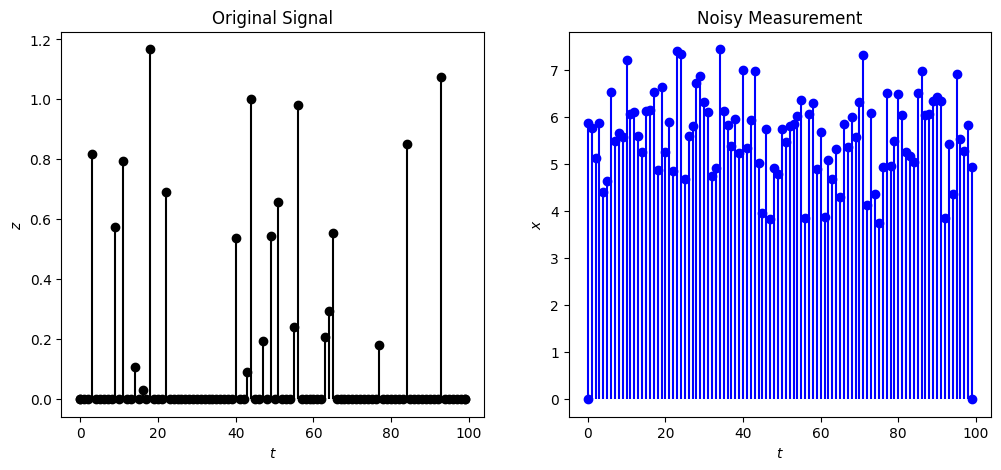

In [3]:
t = np.arange(0, 100, 1)
z = 1.5 * np.random.rand(len(t))
s_lvl = 0.8  #sparsity level
z = z * np.array([0 if np.random.rand() < s_lvl else 1 for i in range(len(t))])
print(f"Sparsity in z: {np.mean(z == 0)}")

A = np.random.rand(100, 100)

sigma = 0.05
noise = np.random.normal(0, sigma)
x = A @ z + noise


fig = plt.figure(1, dpi=100, figsize=(12, 5))
ax  = fig.subplots(nrows=1, ncols=2)
_   = ax[0].stem(t, z, "k", basefmt="ko")
_   = ax[0].set_xlabel(r'$t$')
_   = ax[0].set_ylabel(r'$z$')
_   = ax[0].set_title("Original Signal")

_   = ax[1].stem(t, x, "b", basefmt="bo")
_   = ax[1].set_xlabel(r'$t$')
_   = ax[1].set_ylabel(r'$x$')
_   = ax[1].set_title("Noisy Measurement")

### Task 3.1:

Implement the ISTA class for a fixed number of iterations. For the given signal, plot the total loss and sparse loss as a function of iterations. Also plot the recovered and original signals on a $2 \times 1$ grid.

In [4]:
class ISTA:
    def __init__(self, lambd: float, max_iter=1000):
        """Initialize the ISTA algorithm parameters."""
        self.lambd = lambd
        self.max_iter = max_iter
        self.loss_history_reconstruction = []
        self.loss_history_sparse = []
        self.loss_history_combined = []

    def _soft(self, z: np.ndarray, T: float) -> np.ndarray:
        """Apply soft-thresholding to the input vector."""
        return np.sign(z) * np.maximum(np.abs(z) - T, 0)

    def _run_one_iter(self, z: np.ndarray, x: np.ndarray, A: np.ndarray, alpha: float):
        """Run one iteration of the ISTA algorithm."""

        # Gradient step: z - 1/alpha * A (x - A^T*z)

        gradient = A.T @ (A @ z - x)
        z_new = z - (1 / alpha) * gradient

        # Proximal step: Soft-thresholding with step-size Tau
        tau = self.lambd / (alpha)
        z_new = self._soft(z_new, tau)
        return z_new

    def optimize(self, A: np.ndarray, x: np.ndarray, alpha: float) -> np.ndarray:
        """Optimize the solution using the ISTA algorithm."""
        # Initialize z with zeros
        z = np.zeros(A.shape[1])

        for i in range(self.max_iter):
            z = self._run_one_iter(z, x, A, alpha)

            # Compute the losses
            reconstruction_loss = np.linalg.norm(x - A@z, ord=2)
            sparse_loss = self.lambd * np.linalg.norm(z, ord=1)
            total_loss = reconstruction_loss + sparse_loss

            # Store the losses
            self.loss_history_reconstruction.append(reconstruction_loss)
            self.loss_history_sparse.append(sparse_loss)
            self.loss_history_combined.append(total_loss)

        return z, self.loss_history_combined

    def visualize_loss_history(self):
        """Visualize the loss history over the iterations."""
        # fig, ax = plt.subplots(3, 1, figsize=(10, 15))
        fig, ax = plt.subplots(1, 3, figsize=(18, 5))  # Adjusting to 1 row and 3 columns

        ax[0].plot(self.loss_history_combined, label="Total Loss")
        ax[0].set_title("Total Loss over Iterations")
        ax[0].set_xlabel("Iteration")
        ax[0].set_ylabel("Loss")
        ax[0].legend()

        ax[1].plot(self.loss_history_reconstruction, label="Reconstruction Loss", color='g')
        ax[1].set_title("Reconstruction Loss over Iterations")
        ax[1].set_xlabel("Iteration")
        ax[1].set_ylabel("Loss")
        ax[1].legend()

        ax[2].plot(self.loss_history_sparse, label="Sparse Loss", color='r')
        ax[2].set_title("Sparse Loss over Iterations")
        ax[2].set_xlabel("Iteration")
        ax[2].set_ylabel("Loss")
        ax[2].legend()

        plt.tight_layout()  # Ensures proper spacing between plots
        plt.show()

        # Save ax[0] (Total Loss plot)
        fig_total_loss, ax_total_loss = plt.subplots()
        ax_total_loss.plot(self.loss_history_combined, label="Total Loss")
        ax_total_loss.set_title("Total Loss over Iterations")
        ax_total_loss.set_xlabel("Iteration")
        ax_total_loss.set_ylabel("Loss")
        ax_total_loss.legend()
        #  fig_total_loss.savefig('total_loss_plot.png')
        if self.max_iter==5000:
          fig_total_loss.savefig('total_loss_plot_1.png')
        elif self.max_iter==5001:
          fig_total_loss.savefig('total_loss_plot_2.png')
        else:
          fig_total_loss.savefig('total_loss_plot_3.png')


        # Save ax[2] (Sparse Loss plot)
        fig_sparse_loss, ax_sparse_loss = plt.subplots()
        ax_sparse_loss.plot(self.loss_history_sparse, label="Sparse Loss", color='r')
        ax_sparse_loss.set_title("Sparse Loss over Iterations")
        ax_sparse_loss.set_xlabel("Iteration")
        ax_sparse_loss.set_ylabel("Loss")
        ax_sparse_loss.legend()
        # fig_sparse_loss.savefig('sparse_loss_plot.png')
        if self.max_iter==5000:
          fig_sparse_loss.savefig('sparse_loss_plot_1.png')
        elif self.max_iter==5001:
          fig_sparse_loss.savefig('sparse_loss_plot_2.png')
        else:
          fig_sparse_loss.savefig('sparse_loss_plot_3.png')

        plt.close(fig_total_loss)
        plt.close(fig_sparse_loss)

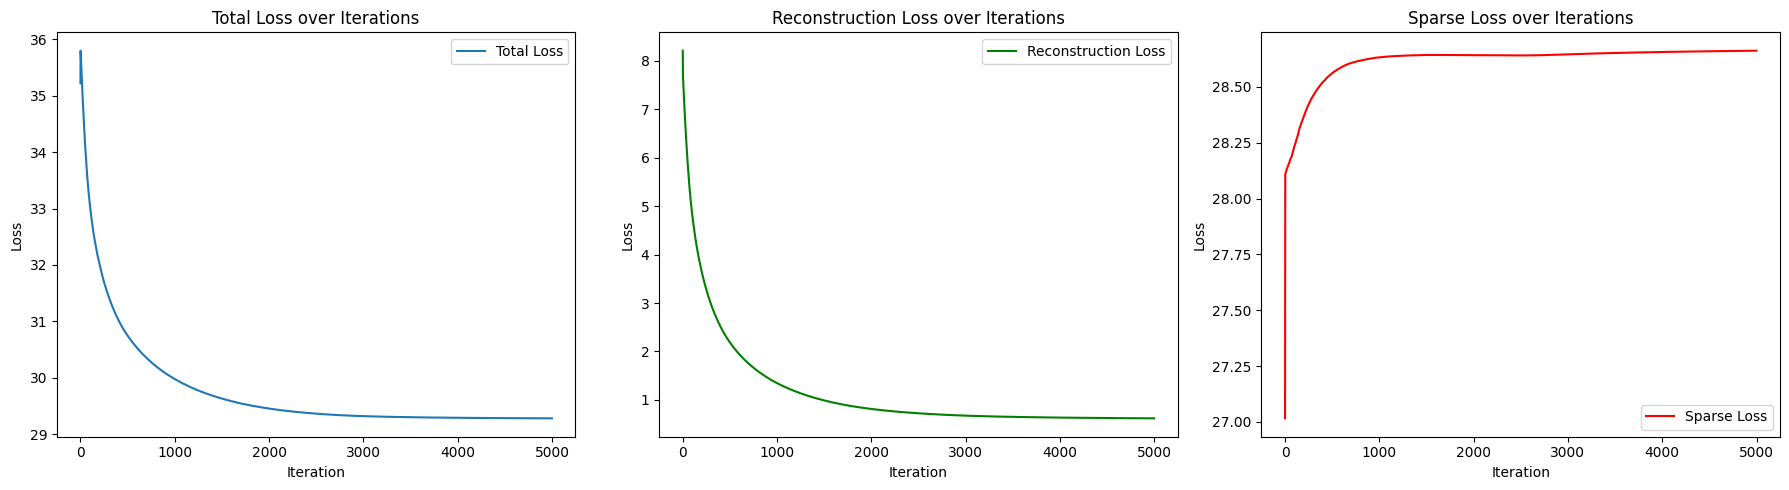

In [5]:
opt = ISTA(2.5, max_iter=5000)
eigs, _ = np.linalg.eig(A.T @ A)
alpha = max(eigs) + 100
z_recovered, _ = opt.optimize(A, x, alpha)
opt.visualize_loss_history()

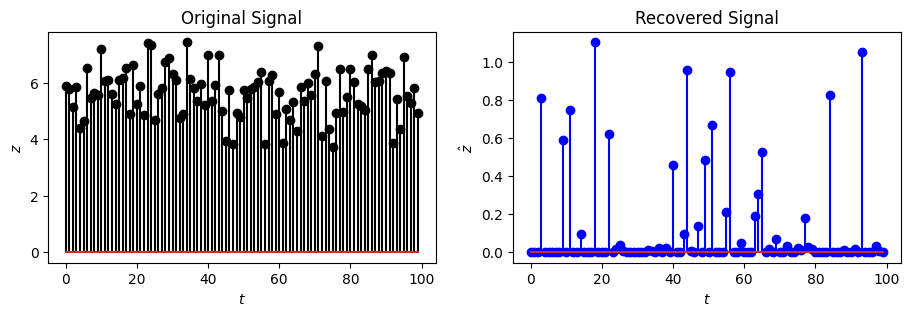

In [6]:
fig = plt.figure(dpi=100, figsize=(11, 3))
ax  = fig.subplots(1, 2)
_   = ax[0].stem(t, x, "k", label="Original Signal")
_   = ax[0].set_xlabel(r'$t$')
_   = ax[0].set_ylabel(r'$z$')
_   = ax[0].set_title("Original Signal")

_   = ax[1].stem(t, z_recovered, "b", label="Recovered Signal")
_   = ax[1].set_xlabel(r'$t$')
_   = ax[1].set_ylabel(r'$\hat{z}$')
_   = ax[1].set_title("Recovered Signal")

### Task 3.2

Add in your response to Task 3.2 from the manual in the cells below.

SPARSITY LEVEL----------------- 0.1


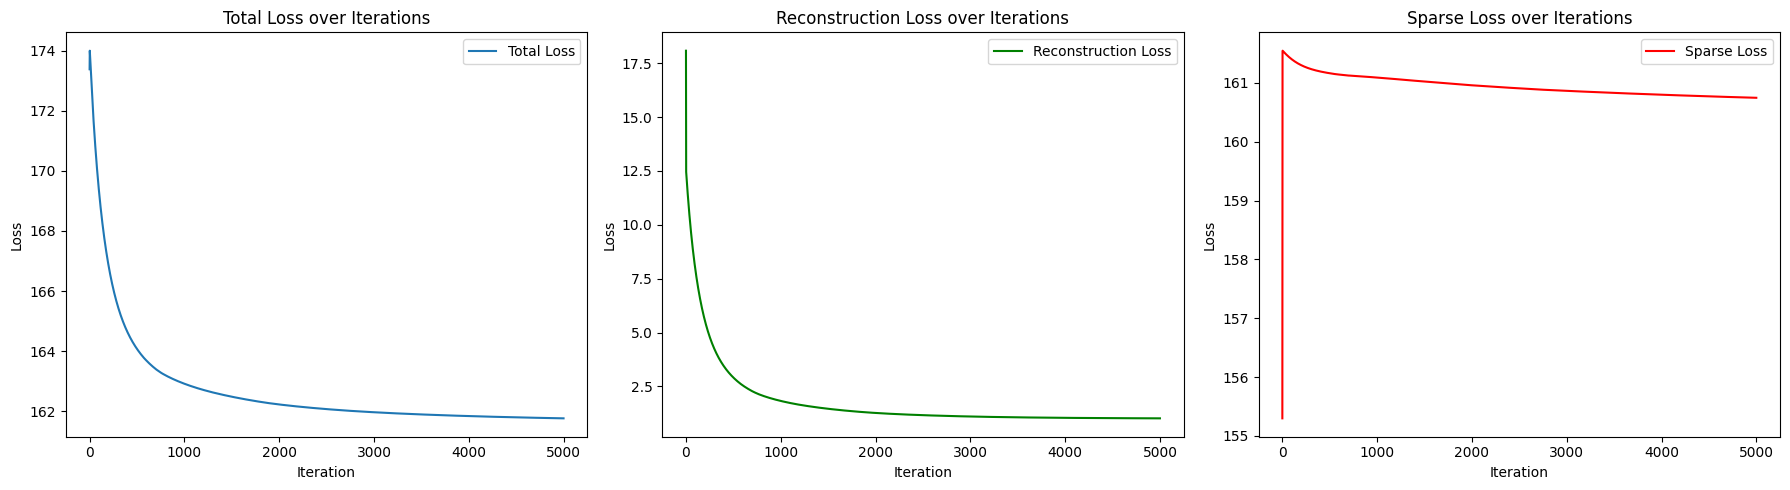

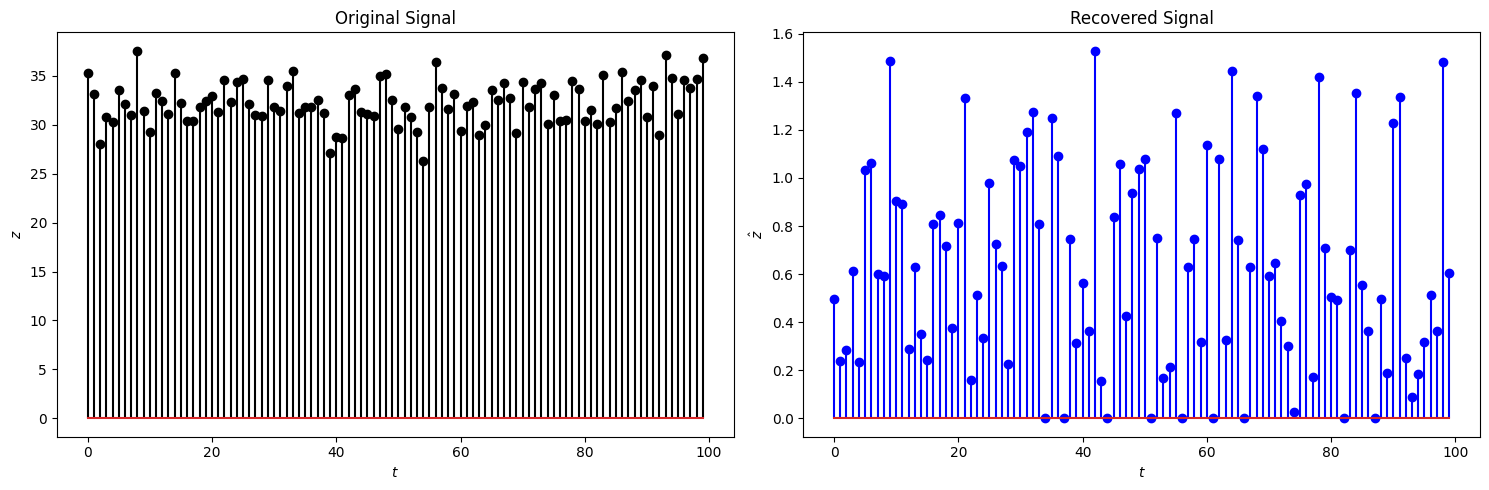

SPARSITY LEVEL----------------- 0.5


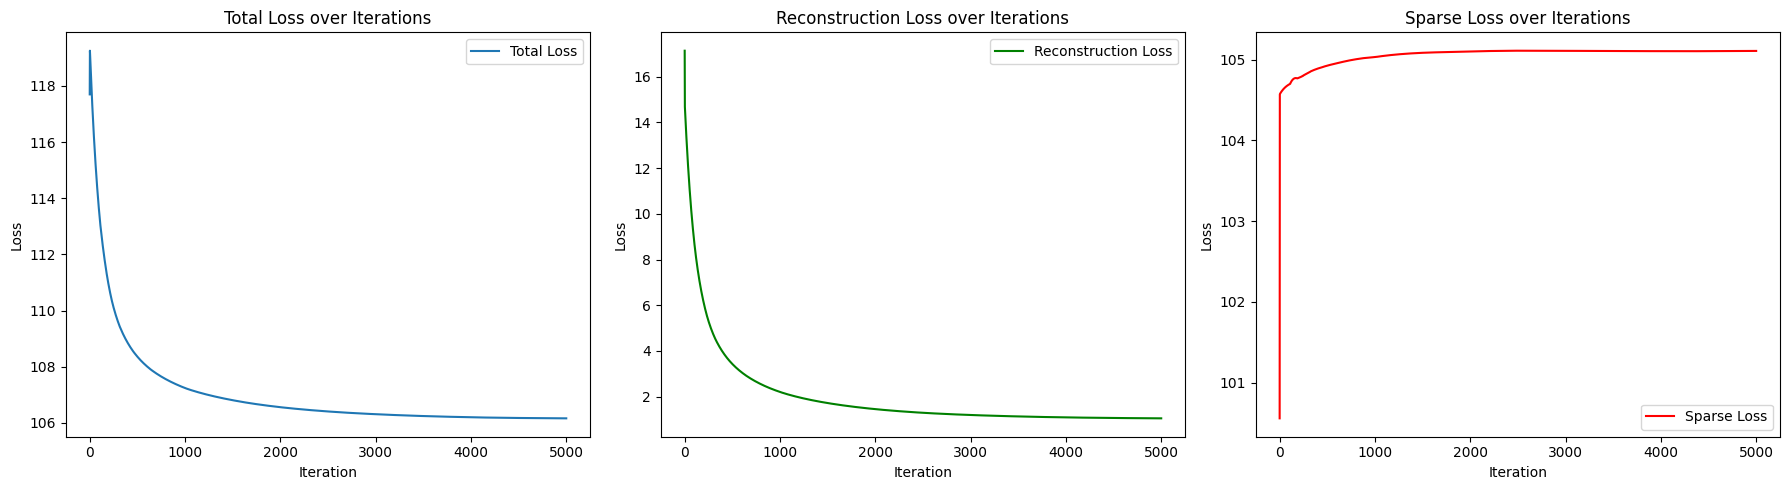

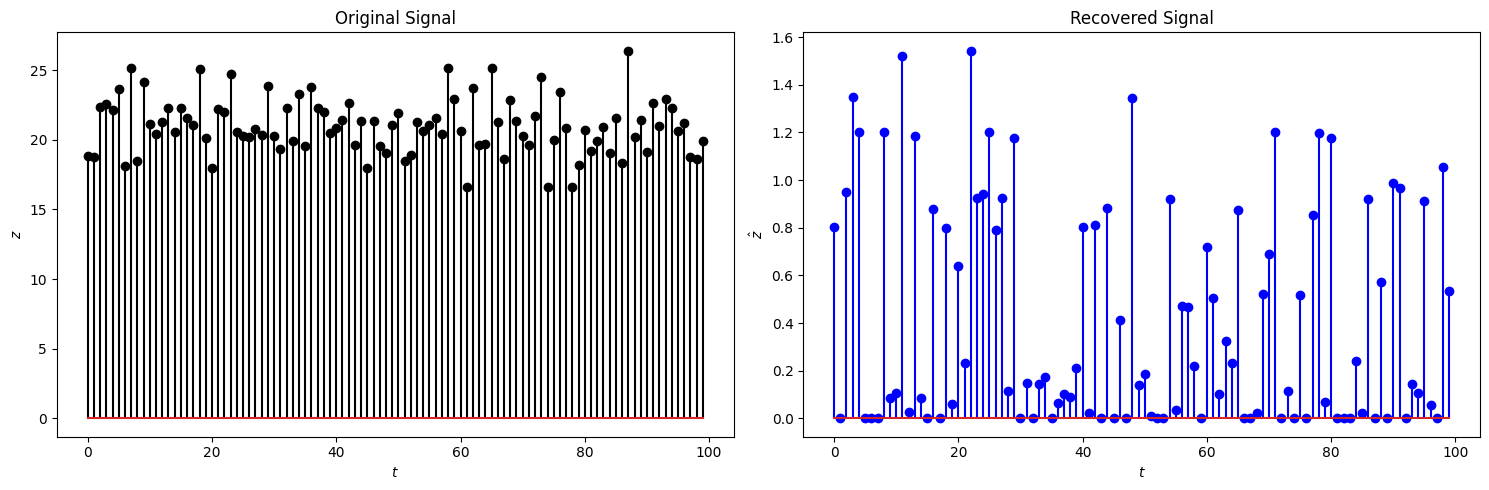

SPARSITY LEVEL----------------- 0.9


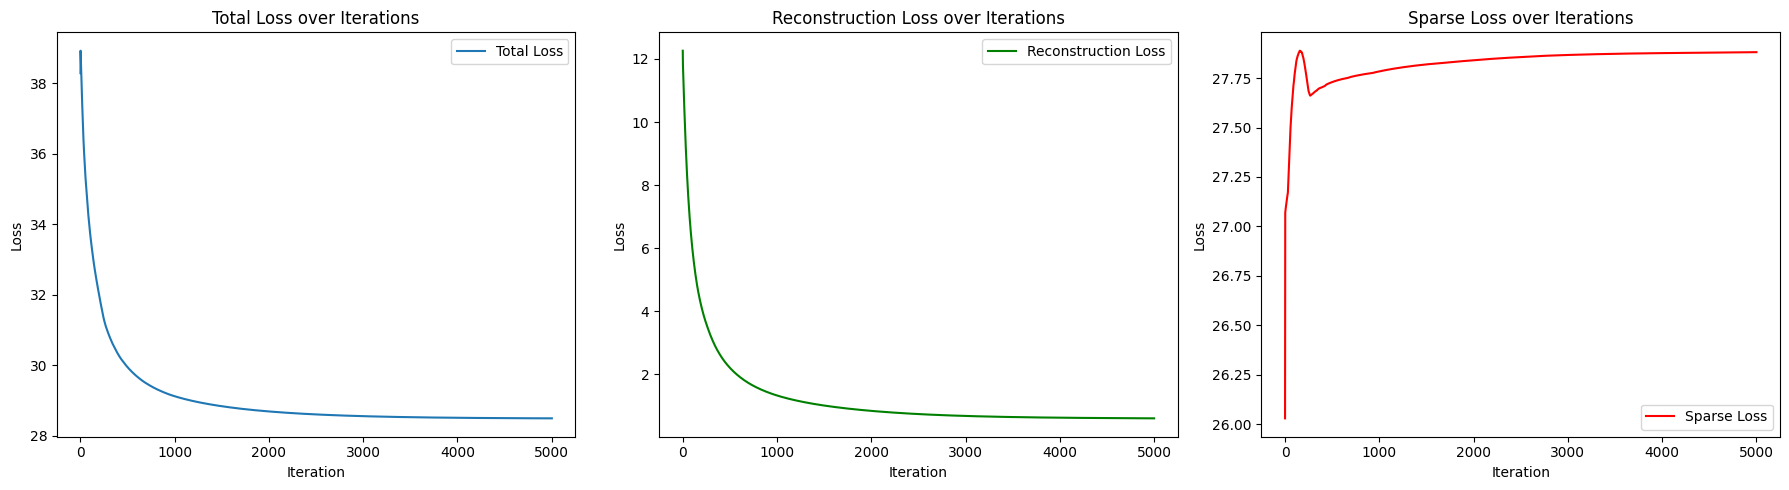

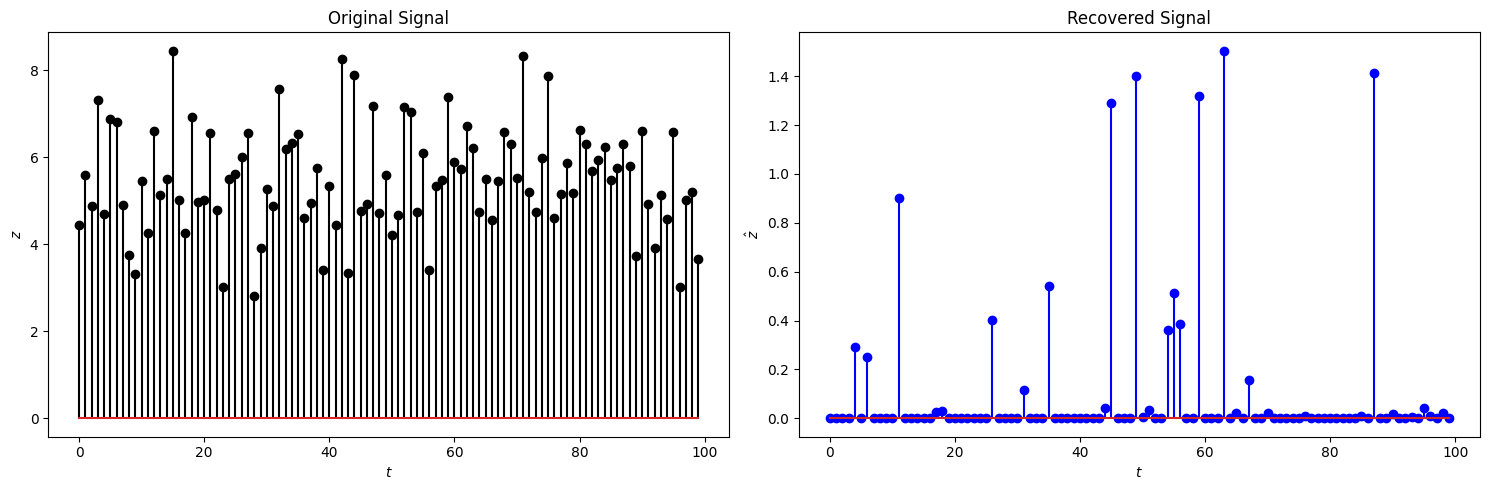

In [7]:
# How does the convergence as well as the recovery of underlying vector z
# change as you change its sparsity level  during its generation?
sparsities = [0.1,0.5,0.9]
for i,k in enumerate(sparsities):
  t = np.arange(0, 100, 1)
  z = 1.5 * np.random.rand(len(t))
  z = z * np.array([0 if np.random.rand() < k else 1 for i in range(len(t))])

  A = np.random.rand(100, 100)

  sigma = 0.05
  noise = np.random.normal(0, sigma)
  x = A @ z + noise

  print("SPARSITY LEVEL-----------------",k)

  opt = ISTA(2.5, max_iter=5000+i)
  eigs, _ = np.linalg.eig(A.T @ A)
  alpha = max(eigs) + 100
  z_recovered, _ = opt.optimize(A, x, alpha)
  opt.visualize_loss_history()

  fig = plt.figure(dpi=100, figsize=(15, 5))  # Adjust the figure size to be wider for side-by-side plots
  ax = fig.subplots(1, 2)  # 1 row, 2 columns for side-by-side plots

  # Original Signal plot
  _ = ax[0].stem(t, x, "k", label="Original Signal")
  _ = ax[0].set_xlabel(r'$t$')
  _ = ax[0].set_ylabel(r'$z$')
  _ = ax[0].set_title("Original Signal")

  # Recovered Signal plot
  _ = ax[1].stem(t, z_recovered, "b", label="Recovered Signal")
  _ = ax[1].set_xlabel(r'$t$')
  _ = ax[1].set_ylabel(r'$\hat{z}$')
  _ = ax[1].set_title("Recovered Signal")

  plt.tight_layout()  # Adjusts the layout to ensure the plots are well spaced
  plt.show()

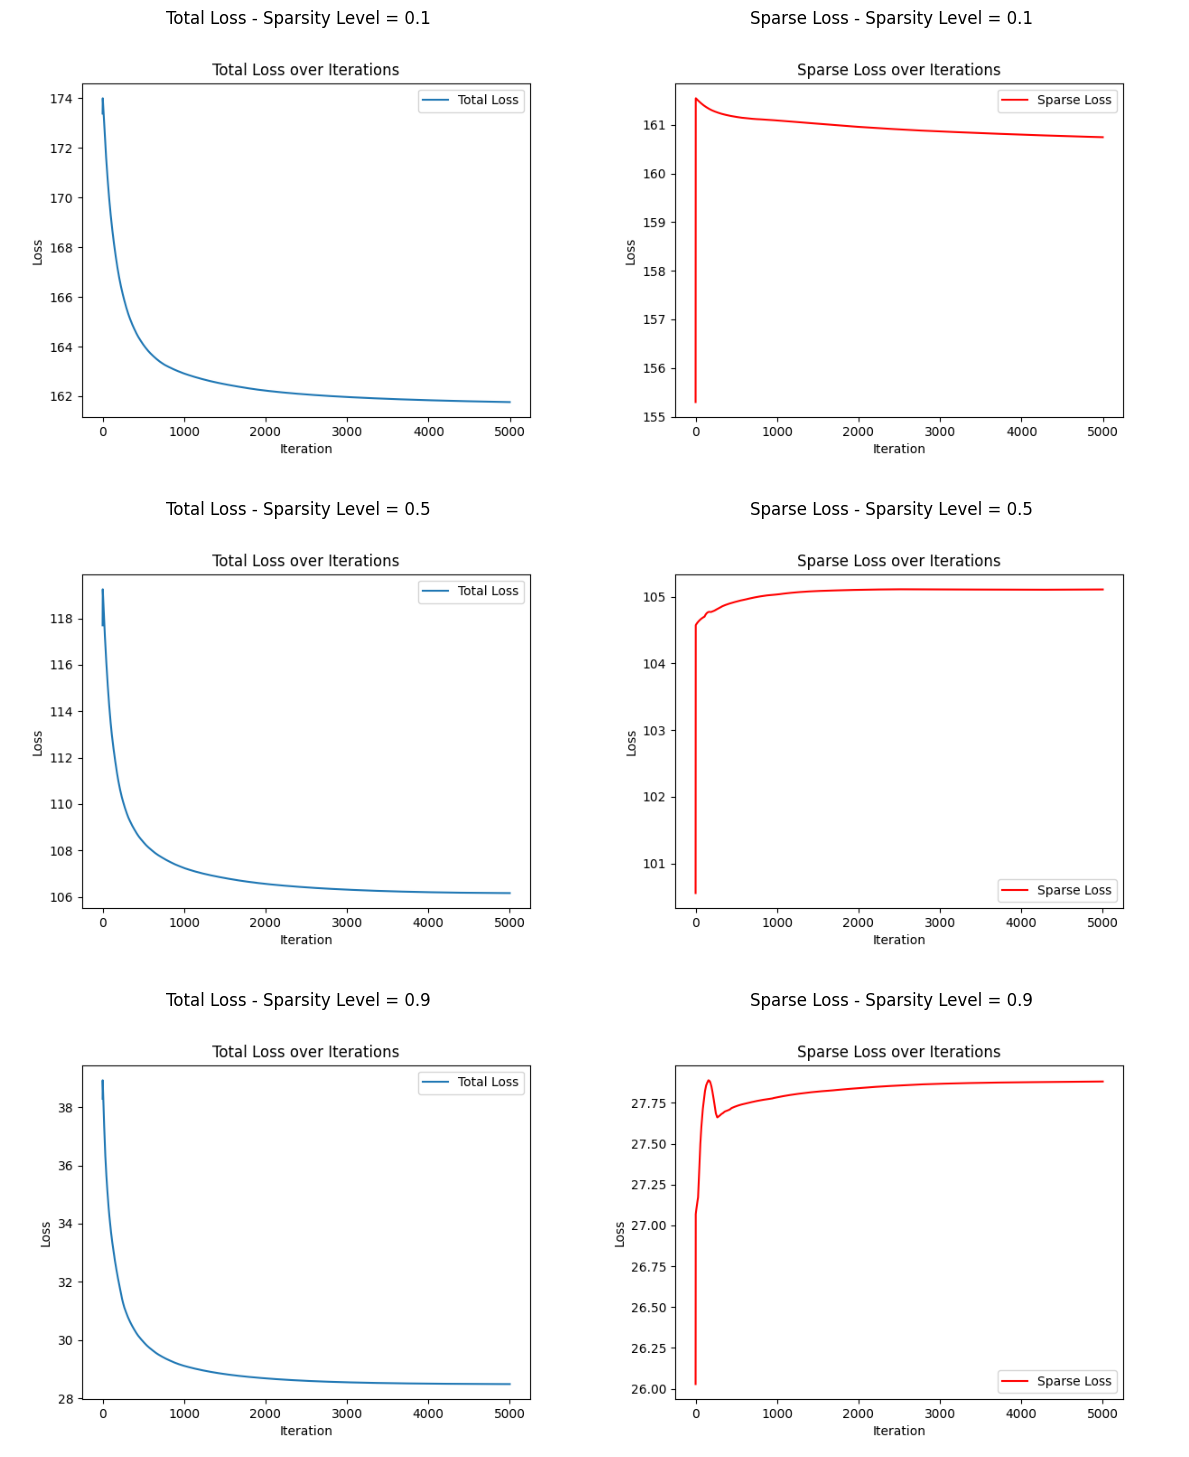

In [8]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg  # For loading images

def plot_saved_loss_plots(total_loss_filenames, sparse_loss_filenames, sparsities):
    """
    Plot saved loss images in a 3x2 layout (Total Loss on the left, Sparse Loss on the right).

    Parameters:
    - total_loss_filenames: A list of filenames for the total loss images to plot.
    - sparse_loss_filenames: A list of filenames for the sparse loss images to plot.
    - sparsities: A list of sparsity levels corresponding to the plots.
    """
    # Create a figure with 3 rows and 2 columns
    fig, ax = plt.subplots(3, 2, figsize=(12, 15))  # Adjust size as needed

    # Loop through each row for total and sparse loss
    for i in range(3):
        # Plot total loss
        total_img = mpimg.imread(total_loss_filenames[i])  # Load the total loss image
        ax[i, 0].imshow(total_img)  # Display the total loss image
        ax[i, 0].axis('off')  # Hide the axes for the image
        ax[i, 0].set_title(f'Total Loss - Sparsity Level = {sparsities[i]}')  # Set title for total loss

        # Plot sparse loss
        sparse_img = mpimg.imread(sparse_loss_filenames[i])  # Load the sparse loss image
        ax[i, 1].imshow(sparse_img)  # Display the sparse loss image
        ax[i, 1].axis('off')  # Hide the axes for the image
        ax[i, 1].set_title(f'Sparse Loss - Sparsity Level = {sparsities[i]}')  # Set title for sparse loss

    plt.tight_layout()  # Ensures proper spacing between plots
    plt.show()  # Display the plots

plot_saved_loss_plots(
    ['total_loss_plot_1.png', 'total_loss_plot_2.png', 'total_loss_plot_3.png'],
    ['sparse_loss_plot_1.png', 'sparse_loss_plot_2.png', 'sparse_loss_plot_3.png'],
    sparsities
)

## Section 2: Unfolding

In section 1, we had the luxury of knowing what our measurement matrix $A$ was. Yet, we had to choose values of $\alpha$ and $\lambda$ manually and a little experimentation will show you that their choice impacts the performance of the algorithm greatly. Our new problem setup assumes that we only have access to some noisy measurements $\mathbf{z}$ and our objective is to recover the underlying sparse signal $\mathbf{z}$ with no knowledge of $\mathbf{A}$.

To do so, we turn our attention towards neural networks.


The following code will help you load and create a dataset from the given `sparse_signals.pkl` file. Do not change it.

The training data comprises of 9000 input $\mathbf{z} \in \mathbb{R}^{100}$ and output $\mathbf{x} \in \mathbb{R}^{100}$ signal pairs while test set contains 1000 samples.

In [9]:
class SparseSignalsDataset(Dataset):
  def __init__(self, Z, X):
    self.z = torch.tensor(np.array(Z), dtype=torch.float32)
    self.x = torch.tensor(np.array(X), dtype=torch.float32)

  def __len__(self):
    return len(self.z)

  def __getitem__(self, idx):
    return self.z[idx], self.x[idx]

In [10]:
def load_file(filename='signals.pkl'):
    with open(filename, 'rb') as f:
        Z, X = pickle.load(f)
    return Z, X

In [11]:
# DO NOT MODIFY
filename = "/content/sparse_signals.pkl"
Z, X = load_file(filename=filename)
dataset = SparseSignalsDataset(Z, X)

batch_size = 32

train_size = int(0.8 * len(dataset))  # 80% for training
test_size = len(dataset) - train_size  # 20% for testing

train_dataset, test_dataset = random_split(dataset, [train_size, test_size], generator=gen)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, generator=gen)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [12]:
len(train_dataset), len(test_dataset)

(8000, 2000)

### Task 3.3

Refer to the manual for this task.

In [13]:
def visualize(model, test_loader, num_samples, configs):
  model.eval()
  fig = plt.figure(figsize=(12, 5))
  axs = fig.subplots(2, num_samples)
  t = np.arange(0, 100, 1)
  with torch.no_grad():
    for i, (z, x) in enumerate(test_loader):
      if i == num_samples:
        break
      z, x = z.to(configs["device"]), x.to(configs["device"])
      z_hat = model(x)[0, :].cpu().numpy()
      z = z[0, :].cpu().numpy()
      _   = axs[0, i].stem(t, z, "k")
      _   = axs[0, i].set_xlabel(r'$t$')
      _   = axs[0, i].set_ylabel(r'$z$')
      _   = axs[0, i].set_title("Original Signal")

      _   = axs[1, i].stem(t, z_hat, "b")
      _   = axs[1, i].set_xlabel(r'$t$')
      _   = axs[1, i].set_ylabel(r'$\hat{z}$')
      _   = axs[1, i].set_title("Recovered Signal")
  plt.tight_layout()
  plt.show()
  return axs

In [14]:
# Ignore the use of x, y here - those are just placeholders

def train(model, train_loader, loss_fn, optimizer, configs):
  model.train()
  epoch_losses = []
  for epoch in range(configs["epochs"]):
    running_loss = 0.0
    for x, y in train_loader:
      x, y = x.to(configs["device"]), y.to(configs["device"])
      optimizer.zero_grad()
      x_hat = model(y)
      loss = loss_fn(x_hat, x)
      loss.backward()
      optimizer.step()
      running_loss += loss.item() * y.size(0)
    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_losses.append(epoch_loss)
    print(f"Epoch: [{epoch+1}/{configs['epochs']}], Loss: {epoch_loss:.4f}")
  return epoch_losses

def evaluate(model, test_loader, loss_fn, configs, tol=1e-6):
  model.eval()
  running_loss = 0.0
  sparsities = []
  with torch.no_grad():
    for x, y in test_loader:
      x, y = x.to(configs["device"]), y.to(configs["device"])
      x_hat = model(y)
      loss = loss_fn(x_hat, x)
      running_loss += loss.item() * y.size(0)
      sparsities.append(torch.sum(torch.abs(x_hat) < tol).item()/x_hat.numel())
  avg_loss = running_loss / len(test_loader.dataset)
  avg_sparsity = np.mean(sparsities)
  print(f"Test Loss: {avg_loss:.4f}")
  print(f"Average Sparsity: {avg_sparsity:.4f}")
  return avg_loss, avg_sparsity

In [15]:
class ISTABlock(nn.Module):
    def __init__(self, input_dim, output_dim):
        """Initialize the ISTA block with a learnable threshold and a linear layer."""
        super().__init__()

        # Linear transformation layer (equivalent to applying a matrix A)
        self.linear = nn.Linear(input_dim, output_dim, bias=False)

        # Learnable threshold (lambda) for soft-thresholding
        # self.threshold = nn.Parameter(torch.Tensor([0.1]), requires_grad=True)
        self.threshold = nn.Parameter(torch.rand(1), requires_grad=True)

    def _soft(self, x, T):
        """Apply soft-thresholding with threshold T."""
        return torch.sign(x) * F.relu(torch.abs(x) - T)

    def forward(self, x):
        """Perform the forward pass through the ISTA block."""

        # Linear transformation step
        z = self.linear(x)
        # Apply soft-thresholding with learnable threshold
        z = self._soft(z, self.threshold)
        return z


class UnfoldedNN(nn.Module):
    def __init__(self, configs):
        """Initialize the unfolded neural network with multiple ISTA blocks."""
        super().__init__()
        # Stack multiple ISTA blocks
        input_dim, output_dim = configs['input_dim'], configs['output_dim']
        num_blocks = len(configs['hidden_dims'])
        self.blocks = nn.ModuleList([ISTABlock(input_dim, output_dim) for _ in range(num_blocks)])

    def forward(self, x):
        """Perform the forward pass through the unfolded neural network."""
        # Pass the input through each ISTA block sequentially
        for block in self.blocks:
            x = block(x)
        return x

In [16]:
configs_unfolded = {
    "input_dim": 100,
    "hidden_dims": [256, 256],
    "output_dim": 100,
    "lr": 1e-3,
    "epochs": 30,
    "batch_size": 32,
    "device": "cuda" if torch.cuda.is_available() else "cpu"
}

Epoch: [1/30], Loss: 0.1512
Epoch: [2/30], Loss: 0.1466
Epoch: [3/30], Loss: 0.1375
Epoch: [4/30], Loss: 0.1275
Epoch: [5/30], Loss: 0.1201
Epoch: [6/30], Loss: 0.1114
Epoch: [7/30], Loss: 0.1019
Epoch: [8/30], Loss: 0.0943
Epoch: [9/30], Loss: 0.0899
Epoch: [10/30], Loss: 0.0865
Epoch: [11/30], Loss: 0.0807
Epoch: [12/30], Loss: 0.0756
Epoch: [13/30], Loss: 0.0732
Epoch: [14/30], Loss: 0.0708
Epoch: [15/30], Loss: 0.0682
Epoch: [16/30], Loss: 0.0661
Epoch: [17/30], Loss: 0.0651
Epoch: [18/30], Loss: 0.0631
Epoch: [19/30], Loss: 0.0620
Epoch: [20/30], Loss: 0.0612
Epoch: [21/30], Loss: 0.0589
Epoch: [22/30], Loss: 0.0567
Epoch: [23/30], Loss: 0.0557
Epoch: [24/30], Loss: 0.0549
Epoch: [25/30], Loss: 0.0530
Epoch: [26/30], Loss: 0.0520
Epoch: [27/30], Loss: 0.0512
Epoch: [28/30], Loss: 0.0506
Epoch: [29/30], Loss: 0.0504
Epoch: [30/30], Loss: 0.0503


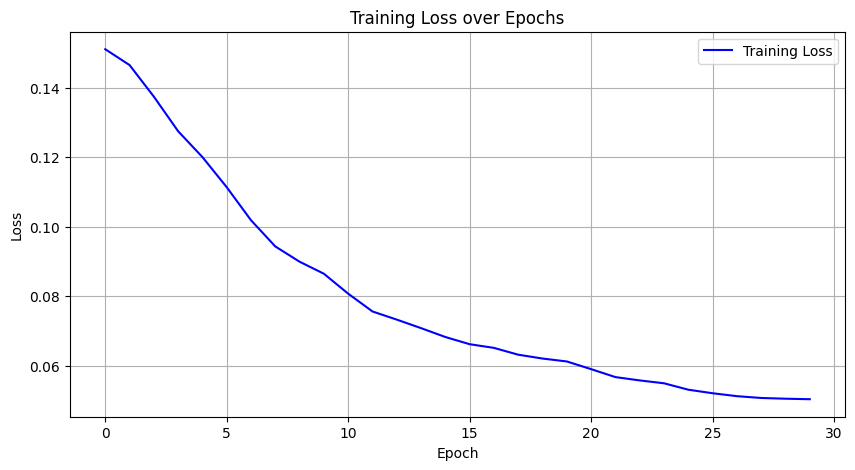

In [17]:
model_unfolded = UnfoldedNN(configs_unfolded).to(configs_unfolded["device"])
optimizer = Adam(model_unfolded.parameters(), lr=configs_unfolded["lr"])
L1 = nn.L1Loss()
epoch_losses = train(model=model_unfolded, train_loader=train_loader, loss_fn=L1, optimizer=optimizer, configs=configs_unfolded)
plt.figure(figsize=(10, 5))
plt.plot(epoch_losses, label='Training Loss', color='blue')
plt.title('Training Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

Test Loss: 0.0511
Average Sparsity: 0.8086


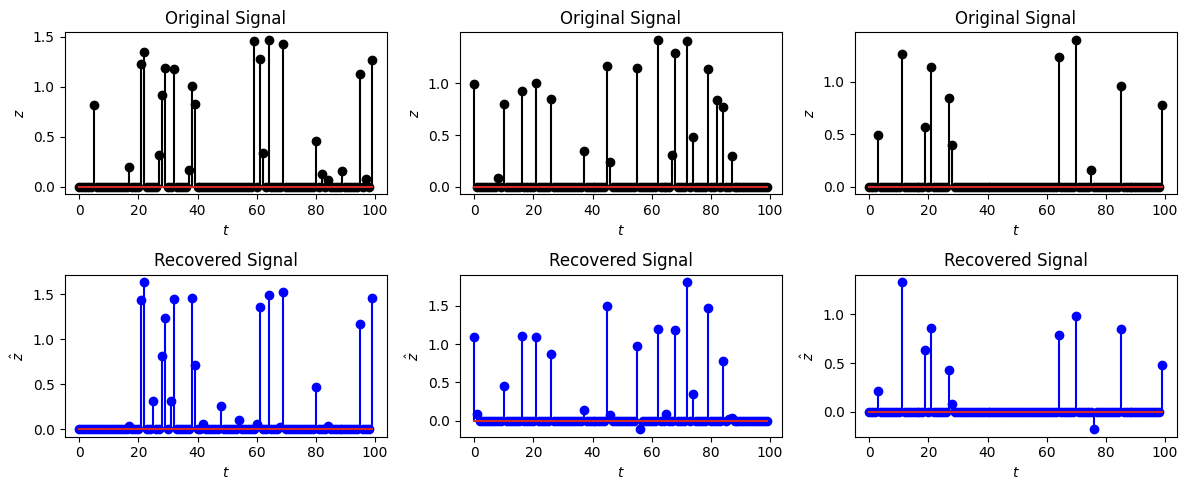

In [18]:
avg_eval_loss_unfolded, avg_eval_sparsity_unfolded = evaluate(model_unfolded, test_loader, L1, configs_unfolded)
_ = visualize(model_unfolded, test_loader, 3, configs_unfolded)

In [19]:
num_params = sum(p.numel() for p in model_unfolded.parameters() if p.requires_grad)
print(f'Number of parameters in model_unfolded: {num_params}')

Number of parameters in model_unfolded: 20002


### Task 3.4

Add in your solution to Task 3.4 from the manual in the cells below.

Epoch: [1/30], Loss: 1.8859
Epoch: [2/30], Loss: 1.0721
Epoch: [3/30], Loss: 0.6844
Epoch: [4/30], Loss: 0.5067
Epoch: [5/30], Loss: 0.4298
Epoch: [6/30], Loss: 0.3891
Epoch: [7/30], Loss: 0.3646
Epoch: [8/30], Loss: 0.3544
Epoch: [9/30], Loss: 0.3300
Epoch: [10/30], Loss: 0.3047
Epoch: [11/30], Loss: 0.2822
Epoch: [12/30], Loss: 0.2669
Epoch: [13/30], Loss: 0.2602
Epoch: [14/30], Loss: 0.2604
Epoch: [15/30], Loss: 0.2557
Epoch: [16/30], Loss: 0.2542
Epoch: [17/30], Loss: 0.2541
Epoch: [18/30], Loss: 0.2492
Epoch: [19/30], Loss: 0.2452
Epoch: [20/30], Loss: 0.2419
Epoch: [21/30], Loss: 0.2370
Epoch: [22/30], Loss: 0.2343
Epoch: [23/30], Loss: 0.2329
Epoch: [24/30], Loss: 0.2308
Epoch: [25/30], Loss: 0.2268
Epoch: [26/30], Loss: 0.2233
Epoch: [27/30], Loss: 0.2191
Epoch: [28/30], Loss: 0.2185
Epoch: [29/30], Loss: 0.2180
Epoch: [30/30], Loss: 0.2148
Test Loss: 0.3032
Average Sparsity: 0.7600


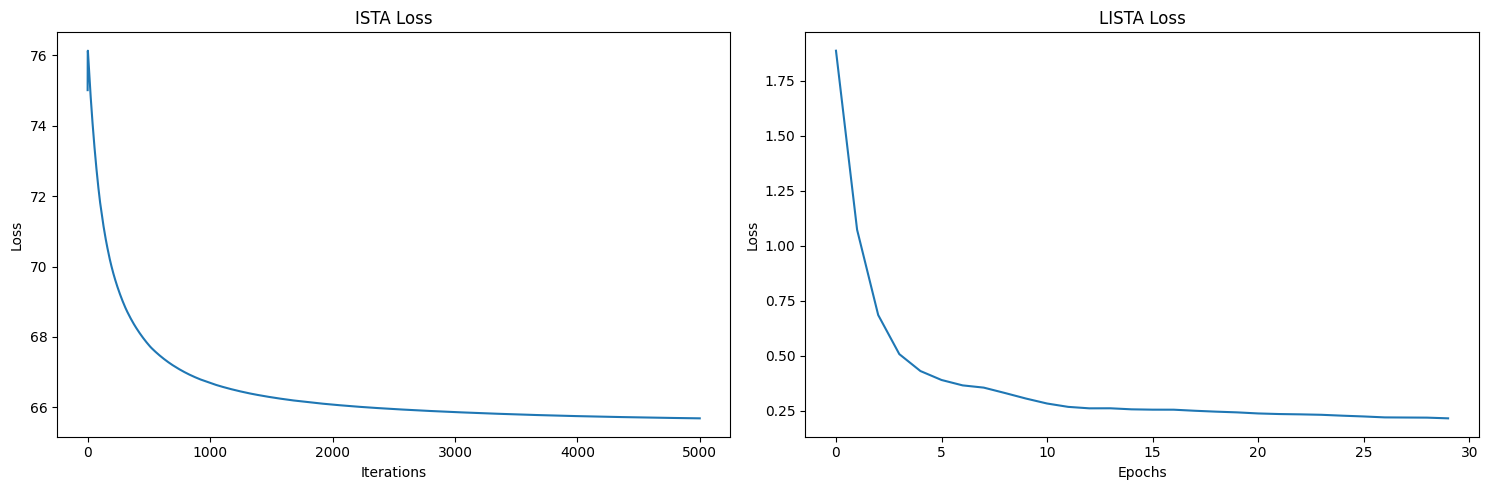

Sparsity induced by ISTA in z_recovered:  0.38
Sparsity in z_true: 0.66
Sparsity induced by LISTA in z_recovered: 0.76


In [24]:
# Compare the convergence of ISTA and LISTA for a given sparsity level of underlying vector z.
# For fair comparison, you may want to match the sparsity levels in both cases.
# Please note that for ISTA, you can directly control the sparsity levels during generation of z


# ---- Create Dataset for Both ISTA and LISTA ----
def generate_sparse_data(s_lvl, A, sigma=0.05):
    t = np.arange(0, 100, 1)
    z = 1.5 * np.random.rand(len(t))
    z = z * np.array([0 if np.random.rand() < s_lvl else 1 for _ in range(len(t))])  # Controlled sparsity level
    noise = np.random.normal(0, sigma, len(t))
    x = A @ z + noise
    return z, x

# ISTA optimization (calling the existing ISTA class)
def run_ista(A, x, z_true, alpha, max_iter=5000):
    ista = ISTA(2.5, max_iter=max_iter)
    z_recovered, ista_losses = ista.optimize(A, x, alpha)
    sparsity_ista = np.mean(z_recovered == 0)  # Calculate sparsity
    return z_recovered, ista_losses, sparsity_ista

# ---- Comparison Function (ISTA vs LISTA) ----
def compare_ista_lista(s_lvl, max_iter_ista=5000, num_train_samples=4):
    # Generate sparse data for ISTA
    A = np.random.rand(100, 100)
    z_true, x = generate_sparse_data(s_lvl, A)
    eigs, _ = np.linalg.eig(A.T @ A)
    alpha = max(eigs) + 100  # Use this for ISTA

    true_s_lvl = np.mean(z_true == 0) #true sparsity level (induced in z)

    # Run ISTA
    z_recovered_ista, ista_losses, sparsity_ista = run_ista(A, x, z_true, alpha, max_iter=max_iter_ista)

    #Creating LISTA testset
    test_dataset = SparseSignalsDataset([z_true], [x])
    test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

    # Generate additional samples for LISTA training
    z_train_true, x_train = [], []
    for _ in range(num_train_samples):
        # A = np.random.rand(100, 100)
        # z_train, x_train_sample = generate_sparse_data(s_lvl, A)
        z_train, x_train_sample = generate_sparse_data(true_s_lvl, A)
        z_train_true.append(z_train)
        x_train.append(x_train_sample)

    # Create dataset for LISTA using the generated training data
    train_dataset = SparseSignalsDataset(z_train_true, x_train)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    # print(len(train_dataset), len(test_dataset))


    # Run LISTA training and evaluation (using your defined `train` and `evaluate` functions)
    model_unfolded = UnfoldedNN(configs_unfolded).to(configs_unfolded["device"])
    optimizer = Adam(model_unfolded.parameters(), lr=configs_unfolded["lr"])
    L1 = nn.L1Loss()
    epoch_losses = train(model=model_unfolded, train_loader=train_loader, loss_fn=L1, optimizer=optimizer, configs=configs_unfolded)
    avg_eval_loss_unfolded, avg_eval_sparsity_unfolded = evaluate(model_unfolded, test_loader, L1, configs_unfolded)

    # ---- Plot Results for Comparison ----
    plt.figure(figsize=(15, 5))

    # ISTA Loss
    plt.subplot(1, 2, 1)
    plt.plot(ista_losses)
    plt.title("ISTA Loss")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")


    # LISTA Loss
    plt.subplot(1, 2, 2)
    plt.plot(epoch_losses)
    plt.title('LISTA Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')

    plt.tight_layout()
    plt.show()


    print(f"Sparsity induced by ISTA in z_recovered:  {sparsity_ista}")
    print(f"Sparsity in z_true: {true_s_lvl}")
    print(f"Sparsity induced by LISTA in z_recovered: {avg_eval_sparsity_unfolded}")


s_lvl = 0.7  # Sparsity level for comparison
compare_ista_lista(s_lvl)

In [ ]:
# Sparsity induced by ISTA in z_recovered:  0.3
# Sparsity in z_true: 0.66
# Sparsity induced by LISTA in z_recovered: 0.65

# Task 4: ISTA Extension to Matrices and Inclusion of Rank Constraints

So far, we have been working with vectors and sparsity constraints. We now introduce two new challenges:

1. Introducing rank constraints into our problem formulation.
2. Extending our algorithms to matrices (can be used to deal with images, videos etc.)

Note that the rank of a matrix describes the degree of correlation between its rows or columns. A low rank means that most of its rows or columns are similar. In the context of images, a low rank component could be used to represent a background (e.g. a grassy background would have large regions of highly similar pixel values). In the context of videos (assume that each frame is being treated as a vector of dimension $hw$ (height $\times$ width) so that the columns of a matrix represent each frame), a low rank component could represent similarities between successive frames. In other words, such an approach could help us identify constant features and isolating things that change. This is used frequently in medical imaging techniques to isolate outliers from largely similar video/image frames that show blood or tissue.

Mathematically, the rank of a matrix can be captured by the nuclear norm of a matrix $||\mathbf{M}||_{*}$ which basically counts the number of non-zero singular values of $\mathbf{M}$.
The singular values are the non zero elements of the diagonal matrix $\mathbf{\Sigma}$ in the singular value decomposition (SVD) of $\mathbf{M} = \mathbf{U \Sigma V}^{T}$.

Our problem is that we are given some observation $\mathbf{X} \in \mathbb{R}^{a \times b}$ (an image or a video for example) and our objective is to recover a low rank component $\mathbf{L} \in \mathbb{R}^{a \times b}$ and sparse component $\mathbf{S} \in \mathbb{R}^{a \times b}$ such that $\mathbf{X} = \mathbf{AL} + \mathbf{BS}$ where $\mathbf{A}$ and $\mathbf{B}$ represent some linear operations (this is similar to $\mathbf{A}$ in the original least squares regression problem. Also note that in many cases it may be sufficient to for these to be identity matrices, but we shall generalize our formulation). Overall, our optimization problem is:

$$
\begin{align}
\arg \min_{\mathbf{L, S}}{\lambda_{1}||\mathbf{L}||_{*} + \lambda_{2}||\mathbf{S}||_{1} + ||\mathbf{X} - \mathbf{AL} - \mathbf{BS}||_{F}^{2}}
\end{align}
$$

This is also known as Robust Principal Component Analysis (RPCA).

Without going into more details here, the ISTA approach can be extended to this problem formulation via the following two update equations:

$$
\begin{align}
\mathbf{L}_{k+1} &= \text{svt}(
(\mathbf{I} - \frac{1}{L_f} \mathbf{A}^T \mathbf{A}) \mathbf{L}_k - \mathbf{A}^T \mathbf{B} \mathbf{S}_k + \mathbf{A}^T \mathbf{X}, \frac{\lambda_1}{L_f}) \\
\mathbf{S}_{k+1} &= \text{soft}((\mathbf{I} - \frac{1}{L_f} \mathbf{B}^T \mathbf{B}) \mathbf{S}_k - \mathbf{B}^T \mathbf{A} \mathbf{L}_k + \mathbf{B}^T \mathbf{X}, \frac{\lambda_2}{L_f})
\end{align}
$$

You have already seen the soft thresholding operator, the singular value thresholding operator is the proximal gradient operator for the nuclear norm and is defined as follows:

$$
\begin{align}
\text{svt}(\mathbf{X}, \kappa) := \mathbf{U} \, \max(\mathbf{0}, \mathbf{\Sigma} - \kappa\mathbf{I}) \, \mathbf{V}^T
\end{align}
$$

where $\mathbf{U \Sigma V}^{T} = \text{SVD}(\mathbf{X})$

Our focus is not on the details of this optimization algorithm. We shall instead focus on designing a neural network inspired by it.

Note that for each update equation, we can replace the multiplicative matrices by learnable convolutional kernels and thresholds by learnable parameters so that each iteration (layer) looks as follows:

$$
\begin{align}
\mathbf{L}_{k+1} &= \text{svt}(C_{1}^{k} * \mathbf{L}_{k} + C_{2}^{k} * \mathbf{S}_{k} + C_{3}^{k} * \mathbf{X}, \mu_{1})\\
\mathbf{S}_{k+1} &= \text{soft}(K_{1}^{k} * \mathbf{L}_{k} + K_{2}^{k} * \mathbf{S}_{k} + K_{3}^{k} * \mathbf{X}, \mu_{2})
\end{align}
$$

where $C_{i}^{k}$ is the $i^\text{th}$ convolutional kernel of layer $k$ in the $\mathbf{L}$ network and $K_{i}^{k}$ is the $i^\text{th}$ convolutional kernel of layer $k$ in the $\mathbf{S}$ network.

You will be working with the moving MNIST dataset for this problem. Each sample $\mathbf{X} \in \mathbb{R}^{64 \times 64}$ represents a frame from a video containing two mnist digits superimposed on a noisy, low rank background. The functions given below will help you load and visualize the dataset.

In [25]:
class MovingMNISTDataset(Dataset):
    def __init__(self, L, S, X):
        self.L = torch.tensor(np.array(L), dtype=torch.float32)
        self.S = torch.tensor(np.array(S), dtype=torch.float32)
        self.X = torch.tensor(np.array(X), dtype=torch.float32)

        self.L = self.L.view(10, 1000, 64 * 64).permute(1, 2, 0)
        self.S = self.S.view(10, 1000, 64 * 64).permute(1, 2, 0)
        self.X = self.X.view(10, 1000, 64 * 64).permute(1, 2, 0)

        self.L = self.L.unsqueeze(1)
        self.S = self.S.unsqueeze(1)
        self.X = self.X.unsqueeze(1)

        print("L shape:", self.L.shape)
        print("S shape:", self.S.shape)
        print("X shape:", self.X.shape)

    def __len__(self):
        return self.L.size(0)

    def __getitem__(self, idx):
        L_seq = self.L[idx]
        S_seq = self.S[idx]
        X_seq = self.X[idx]

        return L_seq, S_seq, X_seq


In [26]:
def load_mnist(filename='moving_mnist.pkl'):
    with open(filename, 'rb') as f:
        L, S, X = pickle.load(f)
    return L, S, X

In [27]:
# DO NOT MODIFY
filename = "/content/moving_mnist.pkl"
L, S, X = load_mnist(filename=filename)
dataset = MovingMNISTDataset(L, S, X)

batch_size = 32

train_size = int(0.8 * len(dataset))  # 80% for training
test_size = len(dataset) - train_size  # 20% for testing

train_dataset, test_dataset = random_split(dataset, [train_size, test_size], generator=gen)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, generator=gen)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

L shape: torch.Size([1000, 1, 4096, 10])
S shape: torch.Size([1000, 1, 4096, 10])
X shape: torch.Size([1000, 1, 4096, 10])


In [28]:
L.shape, S.shape, X.shape

((10000, 64, 64), (10000, 64, 64), (10000, 64, 64))

In [29]:
len(train_dataset), len(test_dataset)

(800, 200)

Original X shape: (10000, 64, 64)
Original L shape: (10000, 64, 64)
Original S shape: (10000, 64, 64)

Plots for Original
Data  (10, 1000, 64, 64)
Frames  (10, 64, 64)


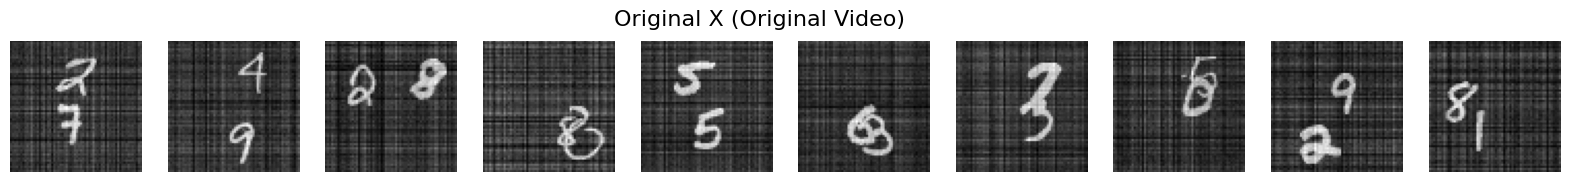

Data  (10, 1000, 64, 64)
Frames  (10, 64, 64)


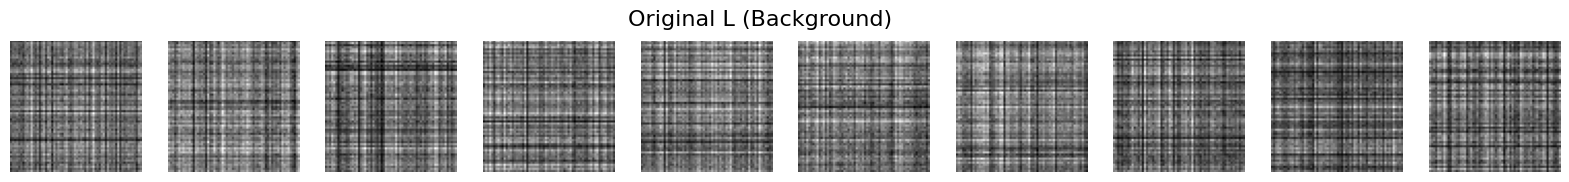

Data  (10, 1000, 64, 64)
Frames  (10, 64, 64)


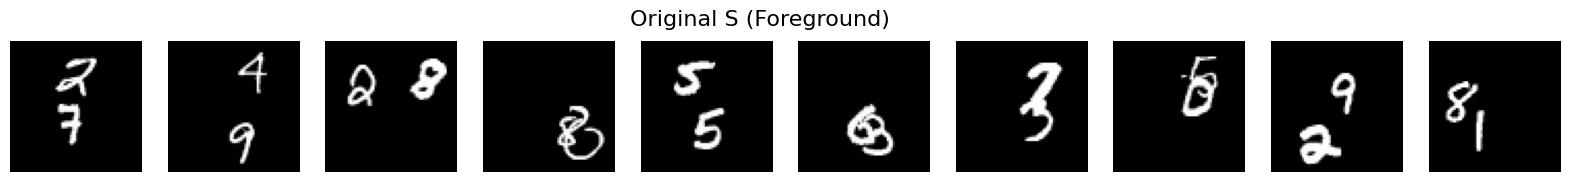



Transformed L_new shape: torch.Size([1, 4096, 10])
Transformed S_new shape: torch.Size([1, 4096, 10])
Transformed X_new shape: torch.Size([1, 4096, 10])


In [30]:
# Display the shape of original data (X)
print("Original X shape:", X.shape)
print("Original L shape:", L.shape)
print("Original S shape:", S.shape)

# Plot the first video frames of original X, L, and S
def plot_video_frames(data, title):
    video_idx = 0  # Selecting the first video (index 0)
    data = data.reshape(10, 1000, 64, 64)
    frames = data[:, video_idx, :, :]  # Shape: (10, 64, 64)

    # frames = data[:10, :, :]

    print("Data ",data.shape)
    print("Frames ",frames.shape)


    # Create a figure with 10 subplots (one for each frame)
    fig, axs = plt.subplots(1, 10, figsize=(20, 2))
    fig.suptitle(title, fontsize=16)

    for i in range(10):
        axs[i].imshow(frames[i], cmap='gray')
        axs[i].axis('off')

    plt.show()

# Plot original X, L, and S
print("\nPlots for Original")
plot_video_frames(X, "Original X (Original Video)")
plot_video_frames(L, "Original L (Background)")
plot_video_frames(S, "Original S (Foreground)")

# Simulating transformation via the dataset
# L_new, S_new, X_new represent transformed data after the dataloader
L_new, S_new, X_new = dataset[0]  # Dataset returns transformed tensors

# Display the shape of transformed data (L_new, S_new, X_new)
print("\n")
print("Transformed L_new shape:", L_new.shape)
print("Transformed S_new shape:", S_new.shape)
print("Transformed X_new shape:", X_new.shape)


Now design a neural network with up to 5 layers based on the intuition for low rank and sparse solutions developed above. Each layer should contain two branches for performing proximal operations for the low rank and sparse component respectively.

During training, plot the following:
1. MSE Loss as a function of the number of epochs.
2. Final values of learnt thresholding parameters for the L and S brances as a function of layer number.

For the test data, plot the following two charts by averaging over all points:
1. Low Rank:
  - 3D plot showing layer number and index of singular value on the x and y axes and the singular values themselves on the z axis.

2. Sparse:
  - 2D plot showing layer number on the x axis and number of sparse values on the y axis.

In [31]:
class ISTABlock(nn.Module):
    def __init__(self, branch, kernel_size=3):
        """Initialize the ISTA block with a convolution layer and a learnable threshold."""
        super(ISTABlock, self).__init__()

        self.branch = branch

        # Convolutional layers for low-rank and sparse components and original input
        self.conv1 = nn.Conv2d(1, 1, kernel_size=kernel_size, padding=kernel_size // 2, bias=False)
        self.conv2 = nn.Conv2d(1, 1, kernel_size=kernel_size, padding=kernel_size // 2, bias=False)
        self.conv3 = nn.Conv2d(1, 1, kernel_size=kernel_size, padding=kernel_size // 2, bias=False)

        self.threshold = nn.Parameter(torch.tensor([0.1]), requires_grad=True)
        # self.threshold = nn.Parameter(torch.rand(1), requires_grad=True)  # Learnable threshold

    def _soft(self, X, thr):
        """Apply soft-thresholding to the input tensor."""
        # return torch.sign(X) * F.relu(torch.abs(X) - thr)
        return torch.sign(X) * torch.maximum(torch.abs(X) - thr, torch.zeros_like(X))

    def _svt(self, X, thr):
        """Apply Singular Value Thresholding (SVT) to the input tensor.
            svt(X,κ):= U*max(0,Σ−κ*I)*V^T where U*Σ*V^T = SVD(X)
        """

        # # Step 1: Compute SVD of the matrix
        # U, S, Vh = svd(X, full_matrices=False)  # SVD decomposition

        # # Step 2: Apply the threshold to the singular values
        # S_thresholded = torch.clamp(S - thr, min=0)  # Subtract threshold thr and keep non-negative values

        # # Step 3: Reconstruct the matrix using the thresholded singular values
        # S_thresholded_diag = torch.diag_embed(S_thresholded)
        # X_svt = torch.matmul(U, torch.matmul(S_thresholded_diag, Vh.mH))

        # print("U shape: ", U.shape)
        # print("S_thresholded shape: ", S_thresholded.shape)
        # print("Vh shape: ", Vh.shape)
        # print("S_thresholded_diag shape: ", S_thresholded_diag.shape)
        # print("X_svt shape: ", X_svt.shape)
        # do()

        # X is of shape (batch_size, channels, height, width)
        batch_size, channels, height, width = X.size()
        X_flat = X.view(batch_size, height, width)

        X_svt = torch.zeros_like(X_flat)

        for i in range(batch_size):
            # Compute SVD of X[i]
            U, S, Vh = torch.linalg.svd(X_flat[i], full_matrices=False)
            # Apply thresholding to singular values
            S_thresholded = torch.maximum(S - thr, torch.zeros_like(S))
            # Reconstruct the matrix
            X_svt_i = U @ torch.diag(S_thresholded) @ Vh
            X_svt[i] = X_svt_i

        # Reshape back to (batch_size, channels, height, width)
        X_svt = X_svt.view(batch_size, 1, height, width)

        return X_svt

    def forward(self, L, S, X):
        """Perform the forward pass through the ISTA block based on the branch type."""
        L_k = self.conv1(L)
        S_k = self.conv2(S)
        X_k = self.conv3(X)
        input_k = L_k + S_k + X_k
        if self.branch == 'L':            # Low-rank branch
            L_kplusone = self._svt(input_k, self.threshold)  # Apply SVT
            return L_kplusone
        else:     # self.branch == 'S':      # Sparse branch
            S_kplusone = self._soft(input_k, self.threshold)  # Apply soft-thresholding
            return S_kplusone


class UnfoldedDNN(nn.Module):
    def __init__(self, configs):
        """Initialize the unfolded neural network with ISTA blocks for both 'S' and 'L' branches."""
        super(UnfoldedDNN, self).__init__()
        kernel = configs['kernel_size']
        self.L_blocks = nn.ModuleList([ISTABlock(branch='L',kernel_size=kernel) for _ in range(configs['num_layers'])])
        self.S_blocks = nn.ModuleList([ISTABlock(branch='S',kernel_size=kernel) for _ in range(configs['num_layers'])])

    def get_thresholds(self):
        """Return the thresholds from both branches of the network."""
        L_params = [block.threshold.item() for block in self.L_blocks]
        S_params = [block.threshold.item() for block in self.S_blocks]
        return S_params, L_params

    def forward(self, D):
        """Perform the forward pass through the unfolded neural network and return activations."""
        activations_L = []
        activations_S = []
        # L_k, S_k = torch.zeros_like(D) , torch.zeros_like(D)  # Initialize low-rank and sparse components
        L_k, S_k = D.clone(), D.clone()  # Initialize low-rank and sparse components
        for L_block, S_block in zip(self.L_blocks, self.S_blocks):
            L_k = L_block(L_k, S_k, D)  # Update low-rank component
            S_k = S_block(L_k, S_k, D)  # Update sparse component
            activations_L.append(L_k)
            activations_S.append(S_k)

        return (activations_L, activations_S), (L_k, S_k)

Now Train the Model and evaluate the outputs. Complete the plotting functions and feel free to change the configurations or training settings

In [32]:
from tqdm import tqdm

def train(model, train_loader, loss_fn, optimizer, configs):
    model.train()
    epoch_losses = []
    L_params = []
    S_params = []

    for epoch in range(configs["epochs"]):
        running_loss = 0.0
        with tqdm(train_loader, desc=f"Epoch [{epoch+1}/{configs['epochs']}]", unit="batch") as pbar:
            for L, S, X in pbar:
                L, S, X = L.to(configs["device"]), S.to(configs["device"]), X.to(configs["device"])
                optimizer.zero_grad()
                _, (L_, S_) = model(X)
                loss = loss_fn(L_, S_, L, S, X)
                loss.backward()
                optimizer.step()
                running_loss += loss.item() * L.size(0)
                pbar.set_postfix(loss=running_loss / len(train_loader.dataset))

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_losses.append(epoch_loss)

        thresholds_S, thresholds_L = model.get_thresholds()
        L_params.append(thresholds_L)
        S_params.append(thresholds_S)

        print(f"Epoch: [{epoch+1}/{configs['epochs']}], Loss: {epoch_loss:.4f}")

    plot_mse_loss(epoch_losses)
    print("\n")
    plot_threshold_params(L_params, S_params)


def evaluate(model, test_loader, loss_fn, configs):
    model.eval()
    running_loss = 0.0
    all_sparsities = []
    all_singular_values = []

    batch_size = configs["batch_size"]

    with torch.no_grad():
        for batch_idx, (L, S, X) in enumerate(test_loader):

            # if L.size(0) < configs["batch_size"]:     #makes no difference
            #   print("skipping-this-iter....shape-err",L.size(0))
            #   break

            L, S, X = L.to(configs["device"]), S.to(configs["device"]), X.to(configs["device"])
            (activations_L, activations_S), (L_ , S_)= model(X)
            loss = loss_fn(L, S, L_, S_, X)
            running_loss += loss.item() * L.size(0)

            print(f"Plot for random frame in {batch_idx}")
            plot_first_frame(L, S, X)

            batch_singular_values = []
            batch_sparsities = []
            layer_idx = 0
            for L_layer, S_layer in zip(activations_L, activations_S):
                layer_idx += 1
                singular_values = get_singular_values(L_layer)
                sparsity = get_sparsity(S_layer)
                batch_singular_values.append(singular_values)
                batch_sparsities.append(sparsity)

            all_singular_values.append(batch_singular_values)
            all_sparsities.append(batch_sparsities)

    avg_loss = running_loss / len(test_loader.dataset)
    print(f"Test Loss: {avg_loss:.4f}")

    avg_singular_values = np.mean(all_singular_values, axis=0)
    avg_sparsities = np.mean(all_sparsities, axis=0)

    plot_singular_values_over_layers(avg_singular_values)
    print("\n")
    plot_sparse_values_over_layers(avg_sparsities)

    return avg_loss


def plot_first_frame(L, S, X):
  L_frame_flat = L[0, 0, :, 0]  # Shape: (4096,)
  S_frame_flat = S[0, 0, :, 0]  # Shape: (4096,)
  X_frame_flat = X[0, 0, :, 0]  # Shape: (4096,)

  L_frame = L_frame_flat.view(64, 64).cpu().numpy()
  S_frame = S_frame_flat.view(64, 64).cpu().numpy()
  X_frame = X_frame_flat.view(64, 64).cpu().numpy()

  fig, axs = plt.subplots(1, 3, figsize=(12, 4))

  axs[0].imshow(L_frame, cmap='gray')
  axs[0].set_title('Background (L)')
  axs[0].axis('off')

  axs[1].imshow(S_frame, cmap='gray')
  axs[1].set_title('Foreground (S)')
  axs[1].axis('off')

  axs[2].imshow(X_frame, cmap='gray')
  axs[2].set_title('Original (D)')
  axs[2].axis('off')

  plt.show()


def loss_fn(L_, S_, L, S, X):
  loss_L = torch.nn.functional.mse_loss(L_, L)
  loss_S = torch.nn.functional.mse_loss(S_, S)
  return loss_L + loss_S


  # print(L_.shape, S_.shape, L.shape, S.shape, X.shape)

  # Reshape the tensors to 2D (flattening the last two dimensions)
  # L_reshaped = L_.view(L_.shape[0], -1, L_.shape[-1])  # Shape: [32, 4096, 10]
  # S_reshaped = S_.view(S_.shape[0], -1, S_.shape[-1])  # Shape: [32, 4096, 10]
  # X_reshaped = X.view(X.shape[0], -1, X.shape[-1])      # Shape: [32, 4096, 10]

  # print(L_reshaped.shape, S_reshaped.shape, X_reshaped.shape)

  # # Compute nuclear norm for each sample in the batch
  # nuclear_norm_L_ = sum(torch.linalg.norm(L_reshaped[i], ord='nuc') for i in range(L_reshaped.shape[0]))

  # # L1 norm of predicted S_ (sum over all elements)
  # # l1_norm_S_ = torch.norm(S_, p=1)
  # l1_norm_S_ = torch.norm(S_reshaped, p=1)

  # # Frobenius norm squared of (X - L_ - S_)
  # # frobenius_norm = torch.norm(X - L_ - S_, p='fro') ** 2
  # frobenius_norm = torch.norm(X_reshaped - L_reshaped - S_reshaped, p='fro') ** 2

  # # print(nuclear_norm_L_, l1_norm_S_, frobenius_norm)

  # # Total loss
  # total_loss = 0.05*nuclear_norm_L_ + 0.005*l1_norm_S_ + frobenius_norm

  return total_loss


In [33]:
def plot_mse_loss(epoch_losses):
    """
    Plot MSE loss over epochs.
    """
    plt.figure(figsize=(10, 5))
    plt.plot(epoch_losses, label='MSE Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('MSE Loss over Epochs')
    plt.legend()
    plt.show()


def plot_threshold_params(L_params, S_params):
    """
    Plot threshold parameters for L and S branches across layers.
    """
    num_epochs = len(L_params)
    num_layers = len(L_params[0])

    epochs = range(1, num_epochs + 1)
    layers = range(1, num_layers + 1)

    # Convert list of lists to numpy arrays
    L_params = np.array(L_params)  # Shape: (num_epochs, num_layers)
    S_params = np.array(S_params)

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    for layer in range(num_layers):
        plt.plot(epochs, L_params[:, layer], label=f'Layer {layer+1}')
    plt.xlabel('Epoch')
    plt.ylabel('Threshold Value')
    plt.title('Thresholds for L Branch over Epochs')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    for layer in range(num_layers):
        plt.plot(epochs, S_params[:, layer], label=f'Layer {layer+1}')
    plt.xlabel('Epoch')
    plt.ylabel('Threshold Value')
    plt.title('Thresholds for S Branch over Epochs')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()


def get_singular_values(L_):
    """
    Calculate singular values from the low-rank component.
    """
    # S = torch.linalg.svdvals(L_.view(L_.size(0), -1))
    # # print(S.shape)
    # k = 20   # Choose k (e.g., 5) so it returns only top 'k' singular values
    # top_k = min(k, S.shape[0])
    # return S[:top_k].cpu().numpy()


    k = 25 # Choose k (e.g., 15) so it returns only top 'k' singular values
    batch_size, channels, height, width = L_.size()
    L_flat = L_.view(batch_size, height, width)
    singular_values = []

    maxval = float('-inf')
    minval = float('inf')

    for i in range(batch_size):
        U, S, Vh = torch.linalg.svd(L_flat[i], full_matrices=False)
        # print(f"Total singular values for matrix {i+1}: {S.shape}")
        maxval = max(maxval, S.shape[0])
        minval = min(minval, S.shape[0])
        singular_values.append(S.cpu().numpy()[:k])

    # print("---------------got new L1---------------".upper(),len(singular_values))

    singular_values_padded = [np.pad(sv, (0, k - len(sv)), 'constant') for sv in singular_values]   # Pad singular values to top_k
    singular_values_padded = np.array(singular_values_padded)        # Average over batch
    avg_singular_values = np.mean(singular_values_padded, axis=0)
    # print("---------------got new L2---------------".upper(),len(singular_values),len(singular_values_padded))
    return avg_singular_values


def get_sparsity(S_, tol=1e-6):
    """
    Calculate sparsity (number of non-zero elements with tolerance 10^-6) from the sparse component.
    """
    # return (torch.abs(S_) > tol).sum().item()
    batch_size = S_.size(0)
    S_flat = S_.view(batch_size, -1)
    num_elements = S_.numel() / batch_size  # Total elements per sample
    zero_counts = ((torch.abs(S_flat) < tol).sum(dim=1)).cpu().numpy()
    sparsity = zero_counts / num_elements  # Fraction of zero elements
    avg_sparsity = np.mean(sparsity)
    return avg_sparsity


def plot_singular_values_over_layers(singular_values):
    """
    Plot singular values for each layer as a 3D surface plot.
    """
    # layers = np.arange(len(singular_values)+1)
    # singular_values = np.array(singular_values)
    # X, Y = np.meshgrid(layers, np.arange(singular_values.shape[1]))

    # fig = plt.figure()
    # ax = fig.add_subplot(111, projection='3d')
    # ax.plot_surface(X, Y, singular_values.T, cmap='viridis')
    # ax.set_xlabel('Layer Number')
    # ax.set_ylabel('Index of Singular Value')
    # ax.set_zlabel('Singular Values')
    # plt.title('Singular Values over Layers')
    # plt.show()

    num_layers = len(singular_values)
    # print("singular ...",singular_values.shape, singular_values[0].shape)
    top_k = singular_values[0].shape[0]
    X = np.arange(1, num_layers + 1)  # Layer numbers
    Y = np.arange(1, top_k + 1)  # Singular value indices
    X, Y = np.meshgrid(X, Y)

    Z = np.array(singular_values).T  # Shape: (top_k, num_layers)

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(X, Y, Z, cmap='viridis')
    ax.set_xlabel('Layer Number')
    ax.set_ylabel('Singular Value Index')
    ax.set_zlabel('Singular Value')
    plt.title('Singular Values over Layers')
    plt.show()


def plot_sparse_values_over_layers(sparse_values):
    """
    Plot average number of sparse values across layers.
    """
    num_layers = len(sparse_values)
    layers = np.arange(1, num_layers + 1)
    plt.figure()
    plt.plot(layers, sparse_values, marker='o')
    plt.xlabel('Layer Number')
    plt.ylabel('Average Sparsity')
    plt.title('Average Sparsity over Layers')
    plt.grid(True)
    plt.show()


Epoch [1/8]: 100%|██████████| 25/25 [00:38<00:00,  1.55s/batch, loss=0.0689]


Epoch: [1/8], Loss: 0.0689


Epoch [2/8]: 100%|██████████| 25/25 [00:47<00:00,  1.92s/batch, loss=0.0539]


Epoch: [2/8], Loss: 0.0539


Epoch [3/8]: 100%|██████████| 25/25 [00:45<00:00,  1.81s/batch, loss=0.0469]


Epoch: [3/8], Loss: 0.0469


Epoch [4/8]: 100%|██████████| 25/25 [00:43<00:00,  1.74s/batch, loss=0.0388]


Epoch: [4/8], Loss: 0.0388


Epoch [5/8]: 100%|██████████| 25/25 [00:45<00:00,  1.83s/batch, loss=0.0313]


Epoch: [5/8], Loss: 0.0313


Epoch [6/8]: 100%|██████████| 25/25 [00:45<00:00,  1.84s/batch, loss=0.0265]


Epoch: [6/8], Loss: 0.0265


Epoch [7/8]: 100%|██████████| 25/25 [00:45<00:00,  1.83s/batch, loss=0.0227]


Epoch: [7/8], Loss: 0.0227


Epoch [8/8]: 100%|██████████| 25/25 [00:48<00:00,  1.94s/batch, loss=0.0194]


Epoch: [8/8], Loss: 0.0194


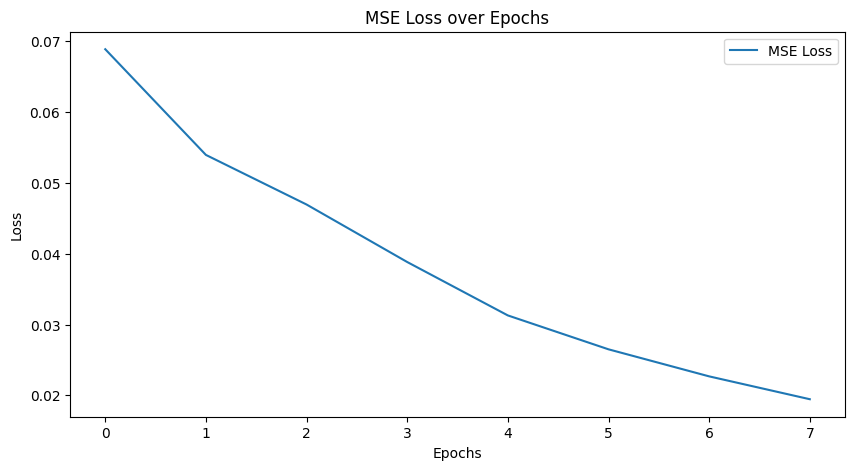

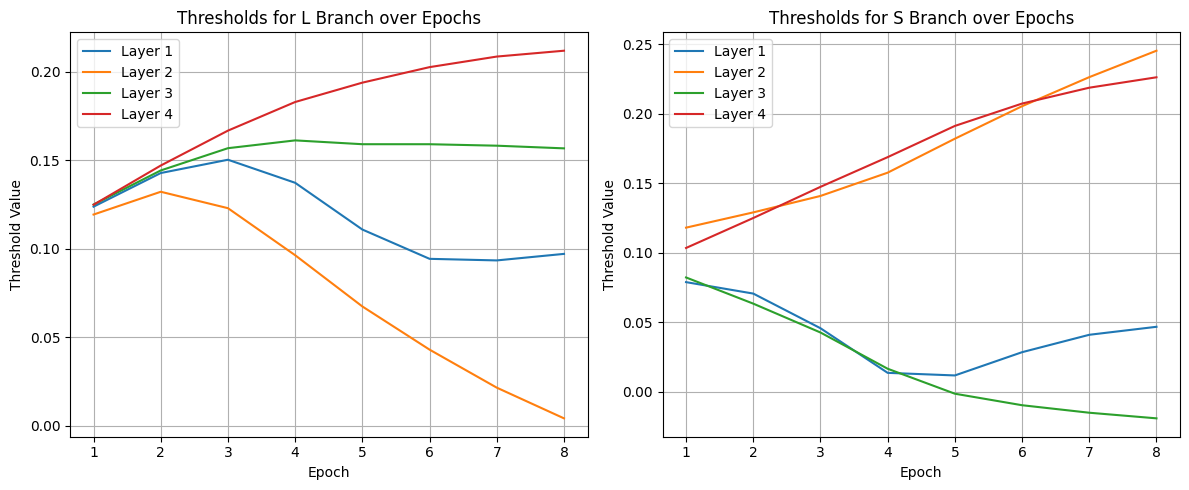

In [34]:
# Model and training configurations
configs = {
    "num_layers": 4,
    "kernel_size": 3,
    "lr": 1e-3,
    "epochs": 8,    #15
    "batch_size": 32,
    "device": "cuda" if torch.cuda.is_available() else "cpu"
}

# Initialize the model, optimizer, and datasets
model = UnfoldedDNN(configs).to(configs["device"])
optimizer = Adam(model.parameters(), lr=configs["lr"])

# Train the model
train(model, train_loader, loss_fn, optimizer, configs)

Plot for random frame in 0


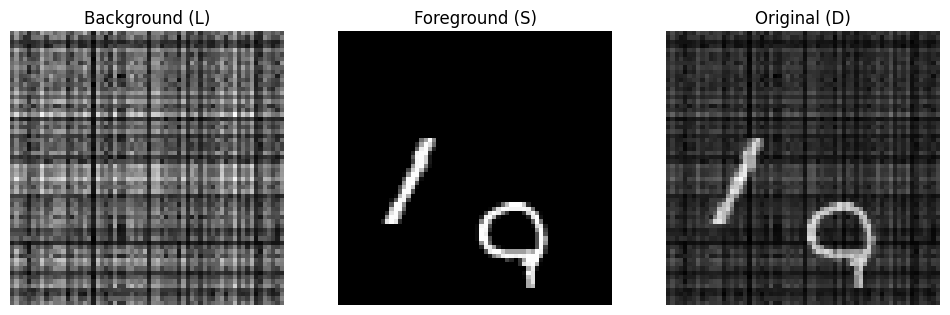

Plot for random frame in 1


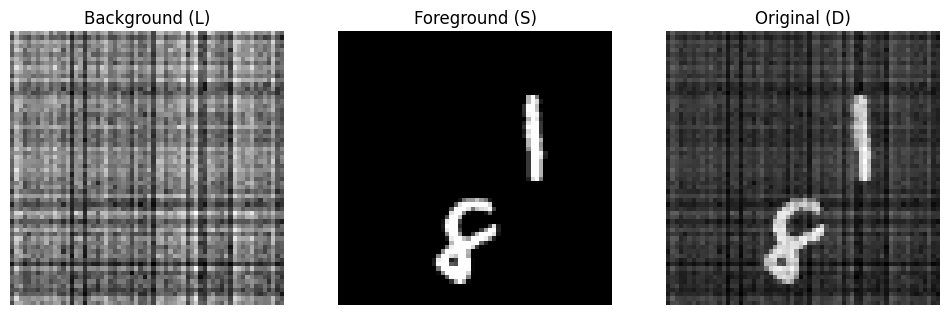

Plot for random frame in 2


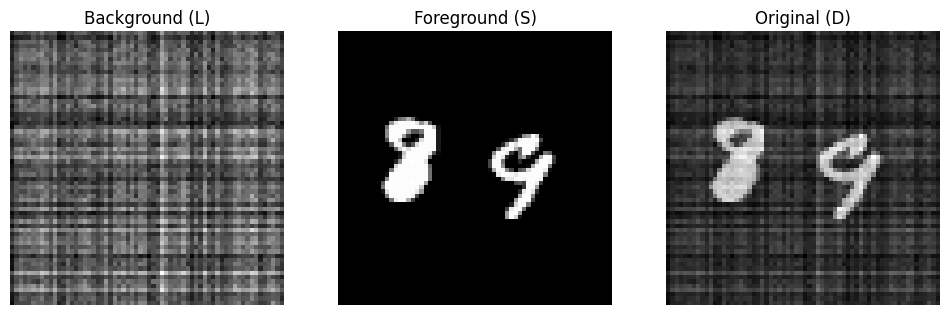

Plot for random frame in 3


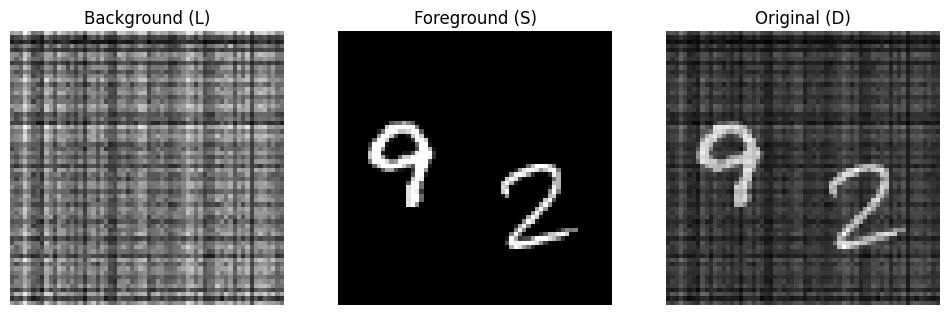

Plot for random frame in 4


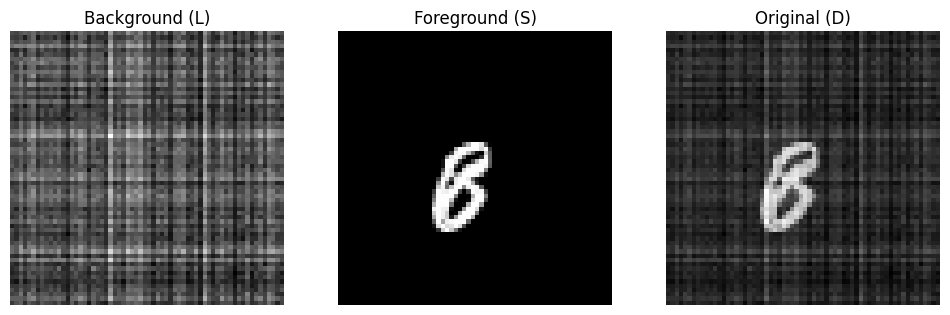

Plot for random frame in 5


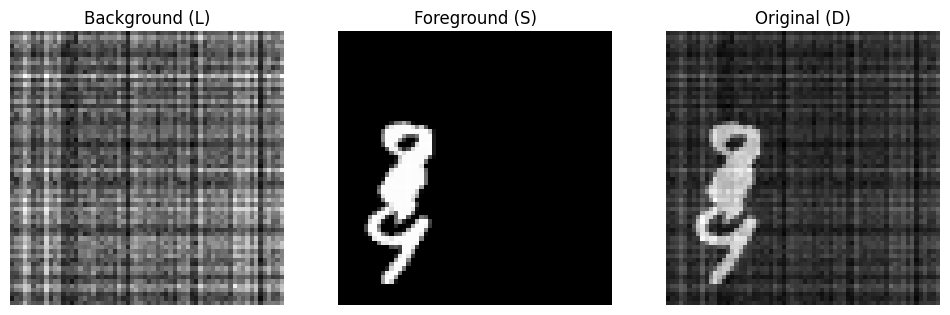

Plot for random frame in 6


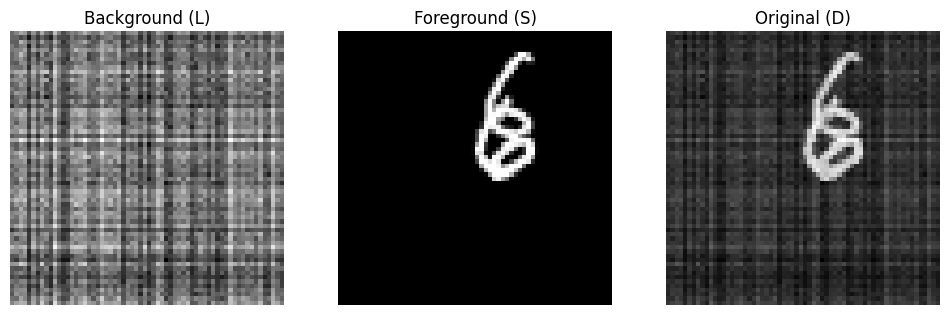

Test Loss: 0.0181


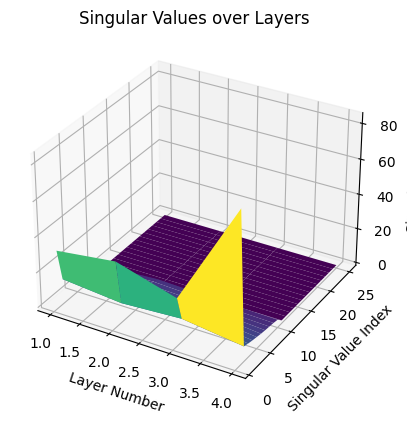

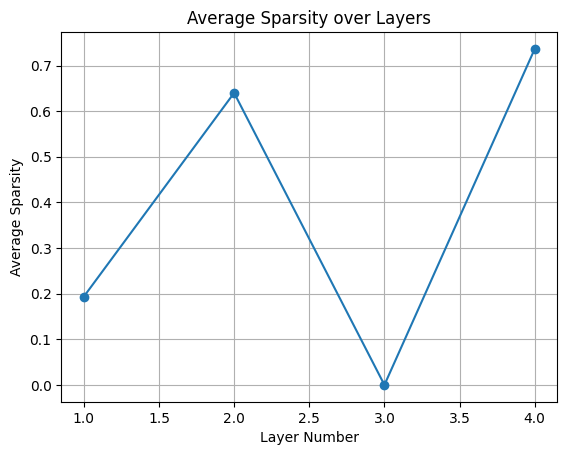

In [35]:
# Evaluate the model
avg_loss = evaluate(model, test_loader, loss_fn, configs)

# Task 5: RPCA with Mixed Norms

Add your solution to this task from the manual in the cells below.

In [36]:
class CORONABlock(nn.Module):
    def __init__(self, branch, kernel_size=3):
        """Initialize the CORONA block with convolution layers and a learnable threshold."""
        super(CORONABlock, self).__init__()

        self.branch = branch

        # Convolutional layers for low-rank and sparse components and original input
        self.conv1 = nn.Conv2d(1, 1, kernel_size=kernel_size, padding=kernel_size // 2, bias=False)
        self.conv2 = nn.Conv2d(1, 1, kernel_size=kernel_size, padding=kernel_size // 2, bias=False)
        self.conv3 = nn.Conv2d(1, 1, kernel_size=kernel_size, padding=kernel_size // 2, bias=False)

        # self.threshold = nn.Parameter(torch.rand(1), requires_grad=True)  # Learnable threshold
        self.threshold = nn.Parameter(torch.tensor([0.1]), requires_grad=True)  # Learnable threshold


    def mixed_1_2_norm(X):
      row_sums = torch.sum(torch.abs(X), dim=1)  # L1 norm of each row
      return torch.sqrt(torch.sum(row_sums ** 2))  # L2 norm of row sums

    def _soft(self, X, thr):
        """
        Apply the proximal operator of the L1,2 mixed norm to the input tensor.
        Prox_L1,2(X, alpha) = max(0, 1 - alpha / ||X||_2) * X
        """
        # Calculate L2 norm along the second axis (rows)
        # X_norm = torch.norm(X, p=2, dim=1, keepdim=True)

        #Calculate L2 norm of X
        Xnorm = torch.norm(X, p=2)

        # Apply the L_1,2 mixed norm proximal operator
        Xthresholded = X * (torch.clamp(1 - (thr / Xnorm), min=0))

        return Xthresholded

    def _svt(self, X, thr):
        """Apply Singular Value Thresholding (SVT) to the input tensor."""
        # U, S, Vh = svd(X, full_matrices=False)  # SVD decomposition
        # S_thresholded = torch.clamp(S - thr, min=0)  # Subtract threshold thr and keep non-negative values
        # S_thresholded_diag = torch.diag_embed(S_thresholded)
        # X_svt = torch.matmul(U, torch.matmul(S_thresholded_diag, Vh.mH))

        # X is of shape (batch_size, channels, height, width)
        batch_size, channels, height, width = X.size()
        X_flat = X.view(batch_size, height, width)

        X_svt = torch.zeros_like(X_flat)

        for i in range(batch_size):
            # Compute SVD of X[i]
            U, S, Vh = torch.linalg.svd(X_flat[i], full_matrices=False)
            # Apply thresholding to singular values
            S_thresholded = torch.maximum(S - thr, torch.zeros_like(S))
            # Reconstruct the matrix
            X_svt_i = U @ torch.diag(S_thresholded) @ Vh
            X_svt[i] = X_svt_i

        # Reshape back to (batch_size, channels, height, width)
        X_svt = X_svt.view(batch_size, 1, height, width)

        return X_svt

    def forward(self, L, S, X):
        """Perform the forward pass through the CORONA block based on the branch type."""
        L_k = self.conv1(L)
        S_k = self.conv2(S)
        X_k = self.conv3(X)
        input_k = L_k + S_k + X_k
        if self.branch == 'L':  # Low-rank branch
            L_kplusone = self._svt(input_k, self.threshold)  # Apply SVT
            return L_kplusone
        else:  # Sparse branch with L1,2 mixed norm
            S_kplusone = self._soft(input_k, self.threshold)  # Apply L1,2 proximal operator
            return S_kplusone

class UnfoldedMixedDNN(nn.Module):
    def __init__(self, configs):
        """Initialize the unfolded neural network with CORONA blocks for both 'S' and 'L' branches."""
        super(UnfoldedMixedDNN, self).__init__()
        kernel = configs['kernel_size']
        self.L_blocks = nn.ModuleList([CORONABlock(branch='L',kernel_size=kernel) for _ in range(configs['num_layers'])])
        self.S_blocks = nn.ModuleList([CORONABlock(branch='S',kernel_size=kernel) for _ in range(configs['num_layers'])])

    def get_thresholds(self):
        """Return the thresholds from both branches of the network."""
        L_params = [block.threshold.item() for block in self.L_blocks]
        S_params = [block.threshold.item() for block in self.S_blocks]
        return S_params, L_params

    def forward(self, D):
        """Perform the forward pass through the unfolded neural network and return activations."""
        activations_L = []
        activations_S = []
        L_k, S_k = D.clone(), D.clone()  # Initialize low-rank and sparse components
        for L_block, S_block in zip(self.L_blocks, self.S_blocks):
            L_k = L_block(L_k, S_k, D)  # Update low-rank component
            S_k = S_block(L_k, S_k, D)  # Update sparse component
            activations_L.append(L_k)
            activations_S.append(S_k)

        return (activations_L, activations_S), (L_k, S_k)


Epoch [1/10]: 100%|██████████| 25/25 [00:46<00:00,  1.86s/batch, loss=0.087]


Epoch: [1/10], Loss: 0.0870


Epoch [2/10]: 100%|██████████| 25/25 [00:49<00:00,  1.99s/batch, loss=0.0561]


Epoch: [2/10], Loss: 0.0561


Epoch [3/10]: 100%|██████████| 25/25 [00:52<00:00,  2.08s/batch, loss=0.0498]


Epoch: [3/10], Loss: 0.0498


Epoch [4/10]: 100%|██████████| 25/25 [00:50<00:00,  2.01s/batch, loss=0.0461]


Epoch: [4/10], Loss: 0.0461


Epoch [5/10]: 100%|██████████| 25/25 [00:44<00:00,  1.78s/batch, loss=0.0435]


Epoch: [5/10], Loss: 0.0435


Epoch [6/10]: 100%|██████████| 25/25 [00:45<00:00,  1.81s/batch, loss=0.0415]


Epoch: [6/10], Loss: 0.0415


Epoch [7/10]: 100%|██████████| 25/25 [00:48<00:00,  1.92s/batch, loss=0.0397]


Epoch: [7/10], Loss: 0.0397


Epoch [8/10]: 100%|██████████| 25/25 [00:44<00:00,  1.76s/batch, loss=0.0382]


Epoch: [8/10], Loss: 0.0382


Epoch [9/10]: 100%|██████████| 25/25 [00:46<00:00,  1.84s/batch, loss=0.0369]


Epoch: [9/10], Loss: 0.0369


Epoch [10/10]: 100%|██████████| 25/25 [00:49<00:00,  1.96s/batch, loss=0.0357]

Epoch: [10/10], Loss: 0.0357


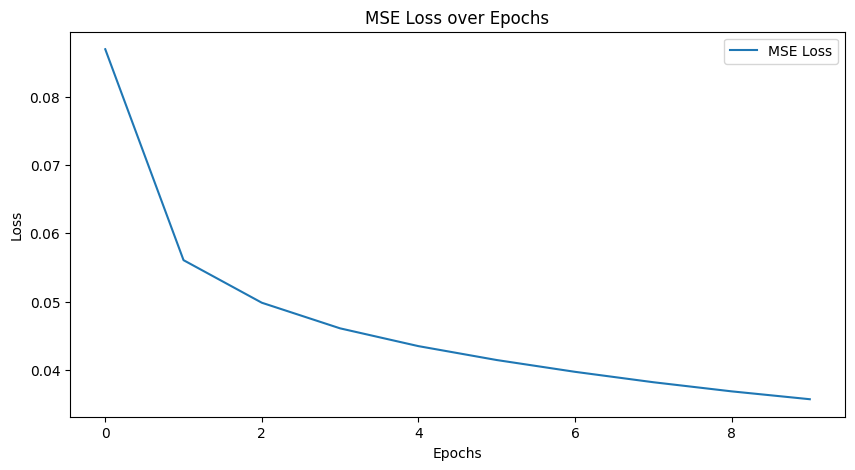

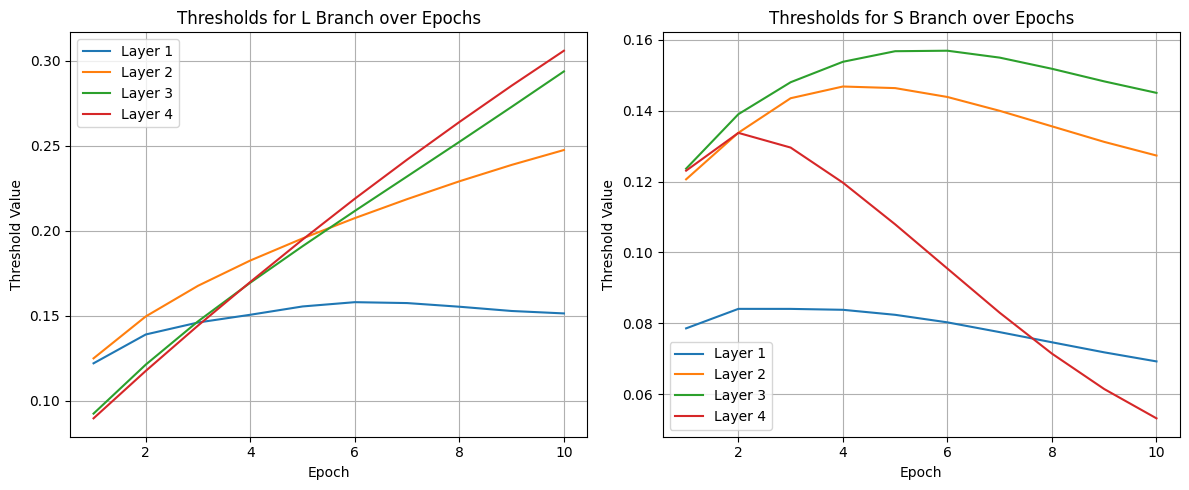

In [52]:
# Model and training configurations
configs = {
    "num_layers": 4,
    "kernel_size": 3,
    "lr": 1e-3,
    "epochs": 10,
    "batch_size": 32,
    "device": "cuda" if torch.cuda.is_available() else "cpu"
}

# Initialize the model, optimizer, and datasets
model = UnfoldedMixedDNN(configs).to(configs["device"])
optimizer = Adam(model.parameters(), lr=configs["lr"])

# Train the model
train(model, train_loader, loss_fn, optimizer, configs)

Plot for random frame in 0


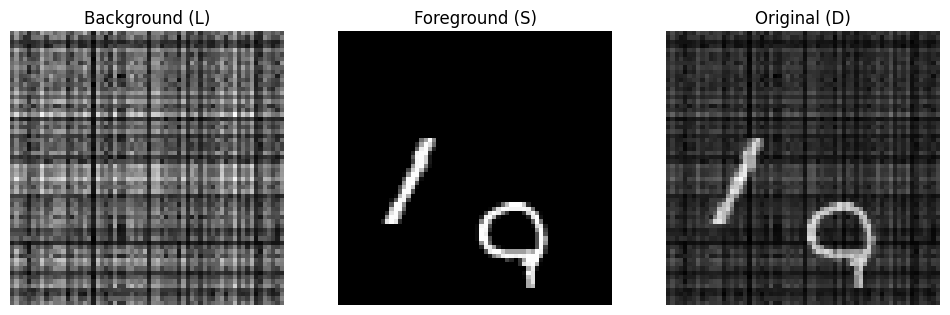

Plot for random frame in 1


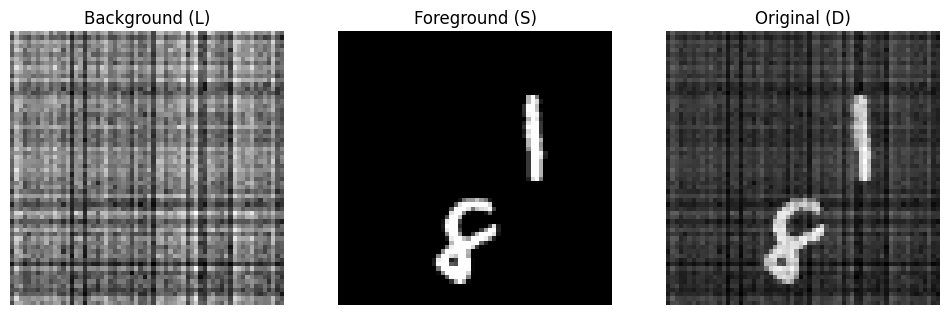

Plot for random frame in 2


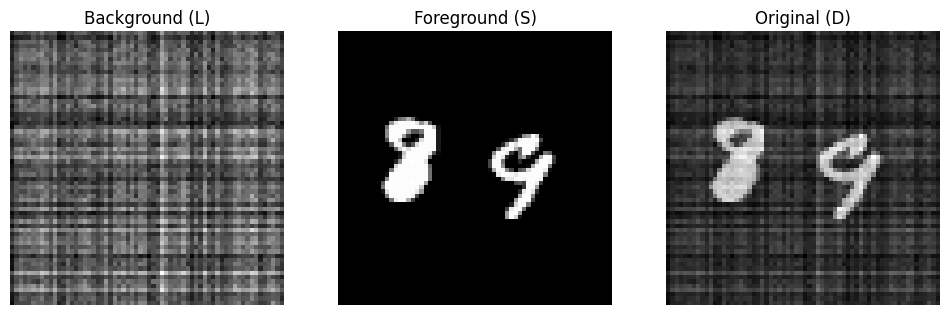

Plot for random frame in 3


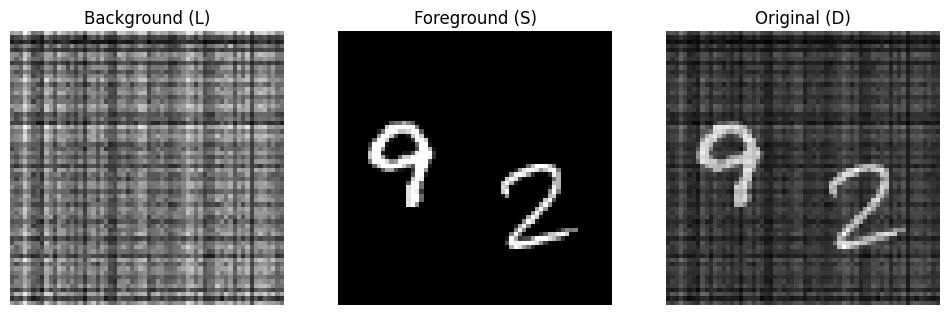

Plot for random frame in 4


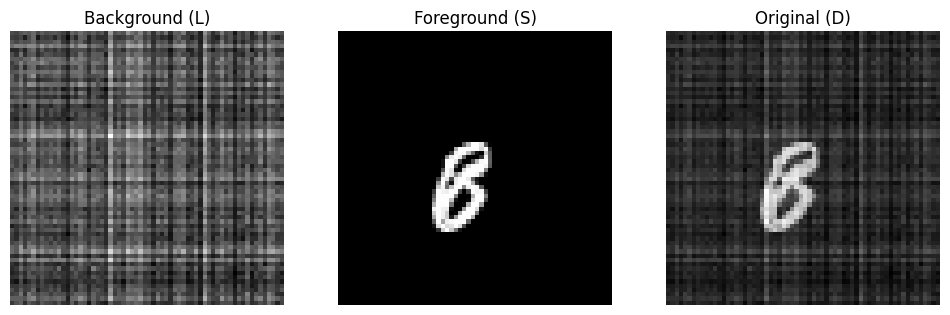

Plot for random frame in 5


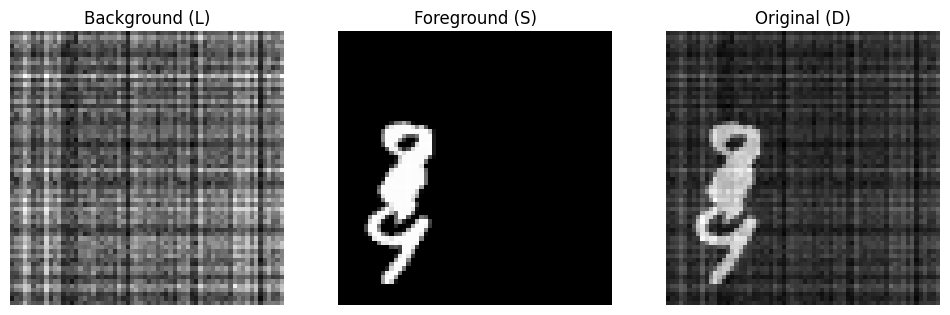

Plot for random frame in 6


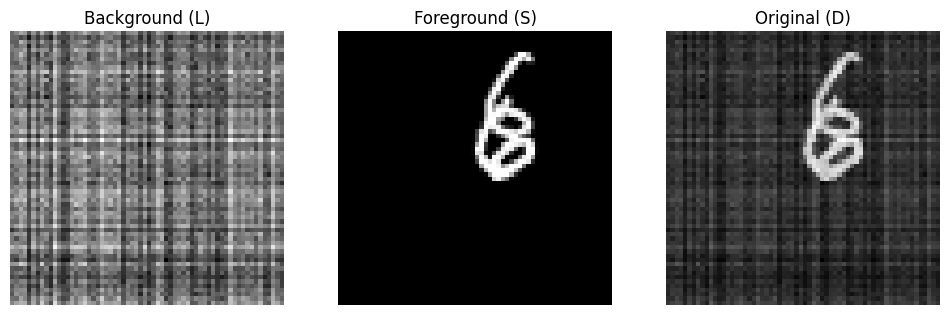

Test Loss: 0.0350


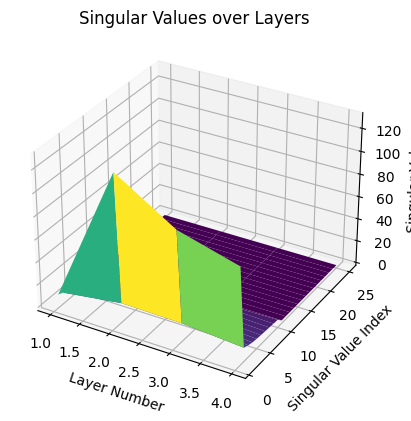

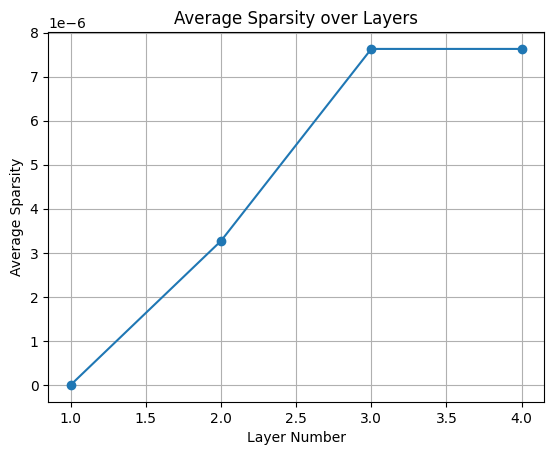

In [53]:
# Evaluate the model
avg_loss = evaluate(model, test_loader, loss_fn, configs)